In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#from bids import BIDSLayout
import numpy as np
import nilearn
from nilearn import datasets, image, plotting, surface, maskers, masking
import nibabel as nib
import pandas as pd
import scipy.io as spio
from nilearn.masking import apply_mask
import scipy
import copy
import gzip
import shutil
import pickle
from distinctipy import distinctipy

#from atlasreader import create_output
#for inline visualization in jupyter notebook
%matplotlib inline

In [2]:
os.chdir('/gpfs/scratch/linjjiang/')

# where are the residuals stored?
# residual_path = '/gpfs/scratch/linjjiang/scan_data/rsa/residual_from_spm'
# roi_path = '/gpfs/scratch/linjjiang/atlases/final_atlas_roi/rsa_atlas_roi'
# out_path = '/gpfs/scratch/linjjiang/scan_data/rsa/full_GLM_atlas_roi'
# spm_path = '/gpfs/scratch/linjjiang/scan_data/spm/output/spatiotemporal_res'

In [3]:
tpl_t1w = t1w = nib.load('atlases/MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii')
print(t1w.shape)

(97, 115, 97)


In [8]:
# create left and right hemisphere mask
data = tpl_t1w.get_fdata()

# Get the affine of the image
affine = tpl_t1w.affine

# Create a mask for the left hemisphere (x < midpoint)
x_midpoint = data.shape[0] // 2
left_mask = np.zeros(data.shape, dtype=bool)
left_mask[:x_midpoint, :, :] = True

# Create a mask for the right hemisphere (x >= midpoint)
right_mask = np.zeros(data.shape, dtype=bool)
right_mask[x_midpoint:, :, :] = True

# Apply the masks to the data
left_data = np.where(left_mask, data, 0)
right_data = np.where(right_mask, data, 0)

# Create new NIfTI images for left and right hemispheres
left_hemisphere_img = image.new_img_like(tpl_t1w, left_data, affine)
right_hemisphere_img = image.new_img_like(tpl_t1w, right_data, affine)

# # Save the new NIfTI images
# left_hemisphere_img.to_filename('left_hemisphere.nii.gz')
# right_hemisphere_img.to_filename('right_hemisphere.nii.gz')

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/plotting/html_stat_map.py:219: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()
/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



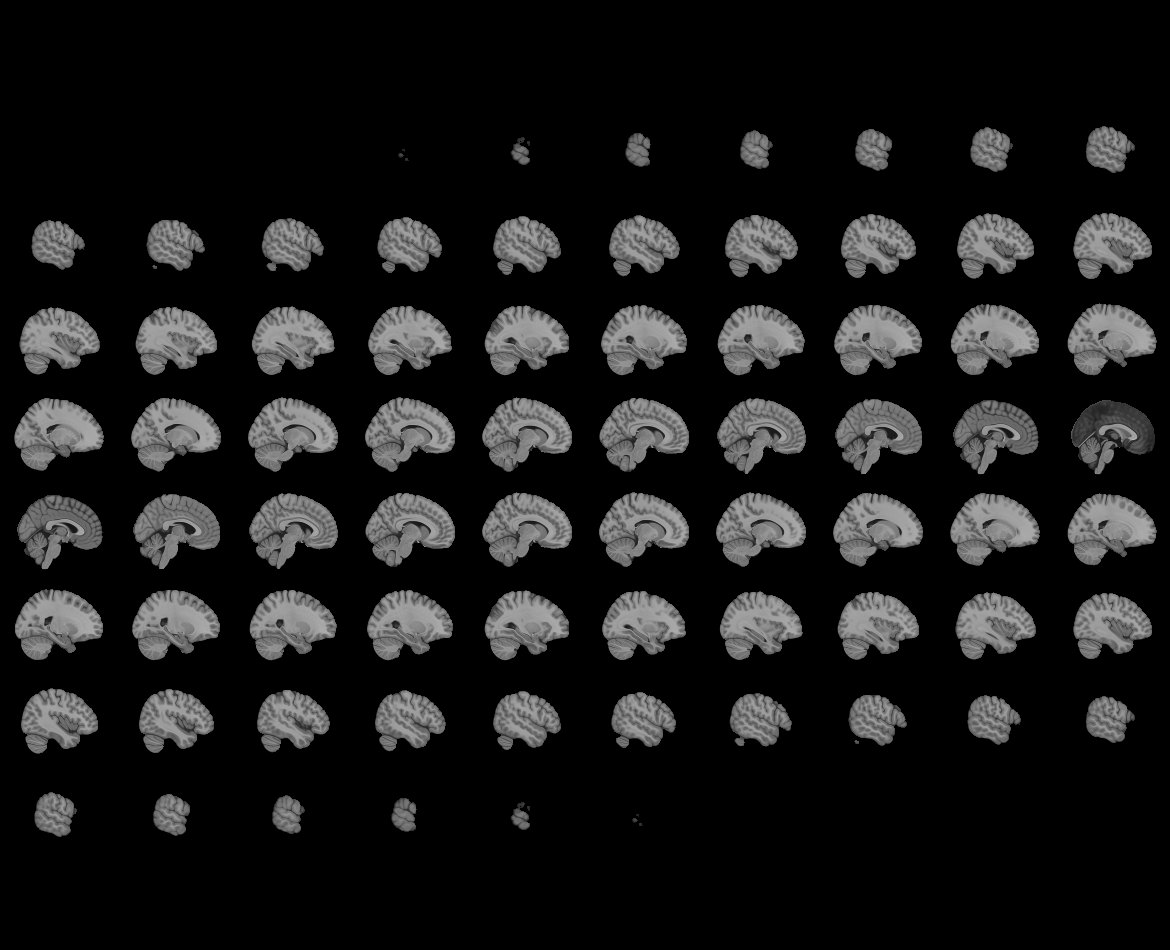
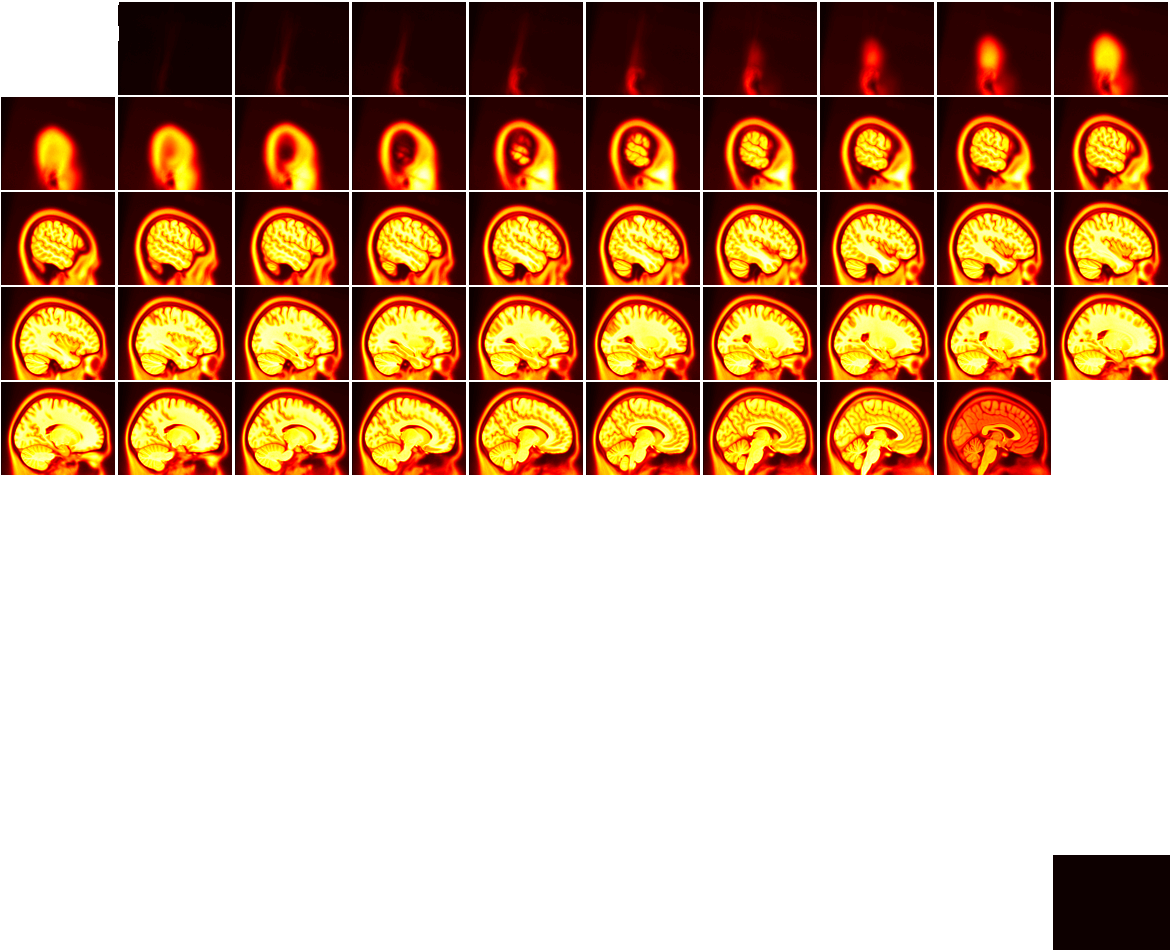

In [10]:
plotting.view_img(left_hemisphere_img)

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



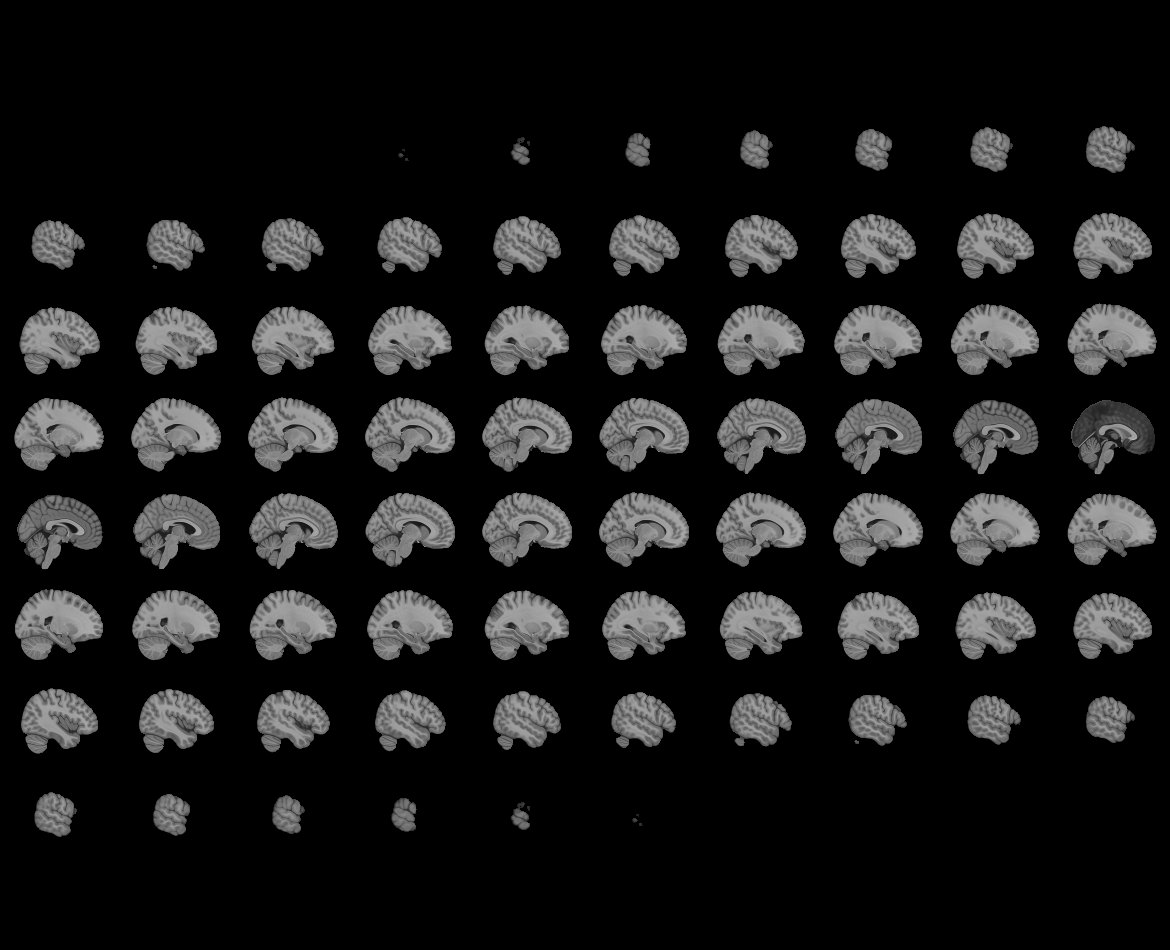
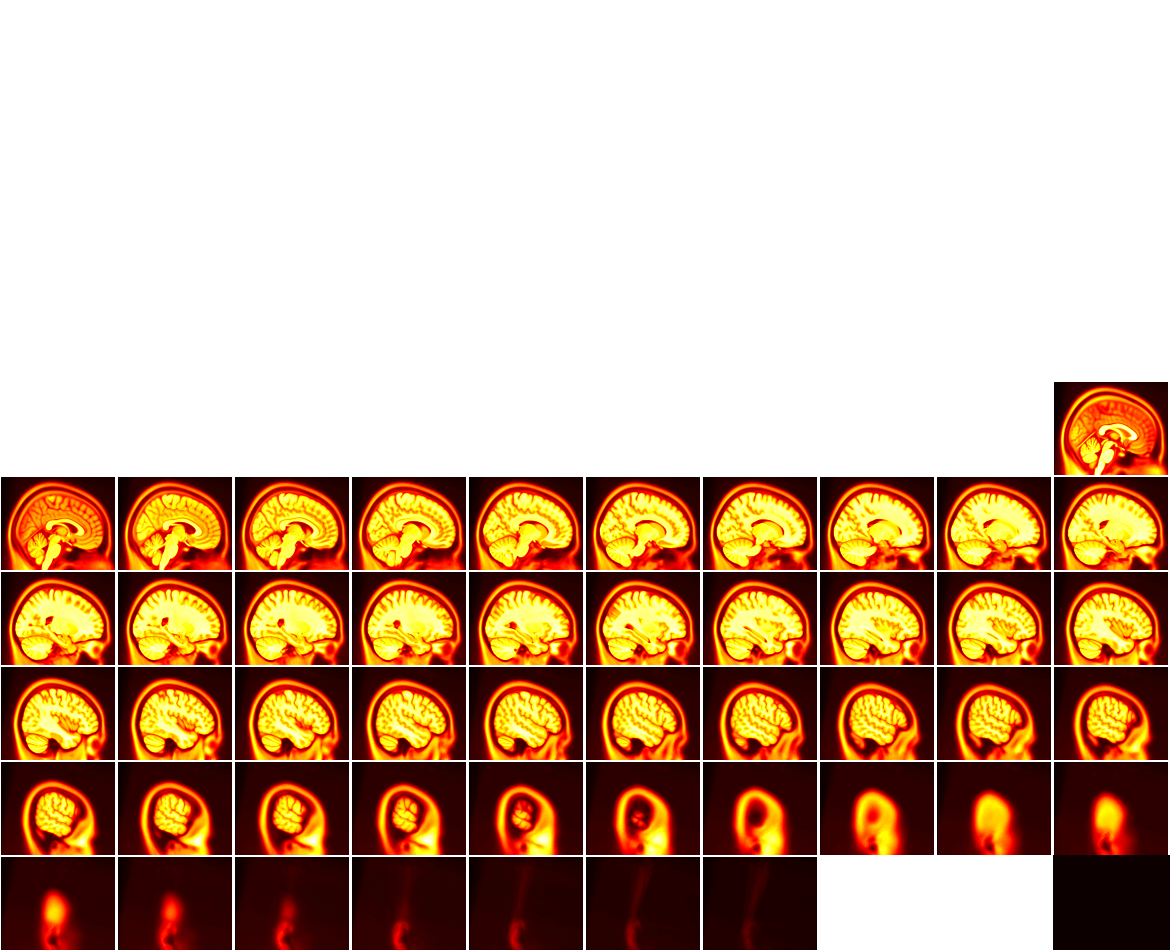

In [11]:
plotting.view_img(right_hemisphere_img)

## Make atlas roi for rsa

### MD

In [12]:
out_path = 'final_atlas_roi/rsa_atlas_roi'

In [13]:
md_roi = nib.load('atlases/MD/MDROI.nii')

# resample the thresholded md image


md_roi = image.resample_to_img(source_img=md_roi,target_img=t1w,interpolation='nearest')

In [14]:
# make the image an integer
md_roi=nilearn.image.math_img('np.round(img)',img=md_roi)
roi_val = nilearn.image.get_data(md_roi)
print(np.unique(roi_val))


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]


In [15]:
# 5/7: left/right SPL;
# 8/9: left/right IFG; 
# 10/11: left/right MFG; 
# 12: SMA; 
# 13/14: PCS/FEF; 
# 21/23; 
# 22/24: MFG?

masks = []
vox_num = []
vals1 = [21,22,8,10,13,5] # sfg, mfg, ifg, ifg/pcs, pcs/fef
vals2 = [23,24,9,11,14,7]
for k in range(6):
    roi_val_2 = roi_val == vals1[k] 
    md_roi_2 = image.new_img_like(
        md_roi, roi_val_2.astype(int)
    )
    roi_val_3 = roi_val == vals2[k] 
    md_roi_3 = image.new_img_like(
        md_roi, roi_val_3.astype(int)
    )
    
    md_roi_1 = nilearn.image.math_img('img1+img2',img1=md_roi_2,img2=md_roi_3)
    vox_num_1 = np.sum(roi_val_2)+np.sum(roi_val_3)
    
    masks.append(md_roi_1)
    vox_num.append(vox_num_1)
    
print('SFG has '+str(vox_num[0])+' voxels;\n',
      'MFG has '+str(vox_num[1])+' voxels;\n',
      'IFG has '+str(vox_num[2])+' voxels;\n',
      'IFG/PCS has '+str(vox_num[3])+' voxels;\n',
      'PCS/FEF has '+str(vox_num[4])+' voxels;\n',
      'SPL has '+str(vox_num[5])+' voxels;\n')


/tmp/ipykernel_2415/1080622855.py:15: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  md_roi_2 = image.new_img_like(
/tmp/ipykernel_2415/1080622855.py:19: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  md_roi_3 = image.new_img_like(


SFG has 1242 voxels;
 MFG has 1424 voxels;
 IFG has 1984 voxels;
 IFG/PCS has 2538 voxels;
 PCS/FEF has 2264 voxels;
 SPL has 8520 voxels;



/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = getattr(ax, type)(data_2d.copy(),


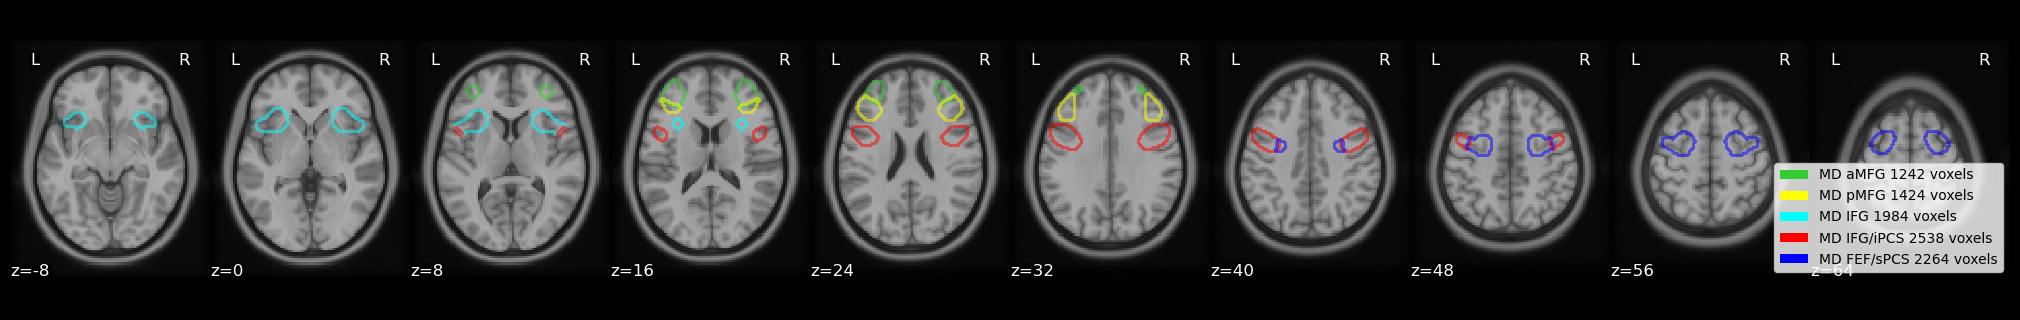

In [16]:

# plot ROI
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(-8,65,8)), figure=fig 
) #2,65,9
#masks = [mfg_aal, sfg_aal, ifg_aal, fef_wang]
#masks = [img_dil_mfg,img_dil_sfg,img_dil_fef]
colors = ["limegreen","yellow","cyan","red","blue"] #"purple"

for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc=colors[0])
p2 = Rectangle((0,0), 1, 1, fc=colors[1])
p3 = Rectangle((0,0), 1, 1, fc=colors[2])
p4 = Rectangle((0,0), 1, 1, fc=colors[3])
p5 = Rectangle((0,0), 1, 1, fc=colors[4])
plt.legend([p1, p2, p3, p4, p5], 
           ["MD aMFG "+str(vox_num[0])+" voxels",
            "MD pMFG "+str(vox_num[1])+" voxels",
            "MD IFG "+str(vox_num[2])+" voxels",
            "MD IFG/iPCS "+str(vox_num[3])+" voxels",
            "MD FEF/sPCS "+str(vox_num[4])+" voxels"], 
           loc="lower right")
plt.show()

In [17]:
masks_bin = []
for mask in masks:
    print(np.unique(mask.get_fdata())) # make sure the image is binarized
    mask_bin = nilearn.image.binarize_img(mask)
    masks_bin.append(mask_bin)
    print(np.unique(mask_bin.get_fdata()))

[0. 1.]


/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [18]:
# save the MD ROI -- for final
nib.save(masks[0], 'atlases/final_atlas_roi/rsa_atlas_roi/amfg-md.nii')
nib.save(masks[1], 'atlases/final_atlas_roi/rsa_atlas_roi/pmfg-md.nii')
nib.save(masks[2], 'atlases/final_atlas_roi/rsa_atlas_roi/ifg-md.nii')
nib.save(masks[3], 'atlases/final_atlas_roi/rsa_atlas_roi/ipcs-md.nii')
nib.save(masks[4], 'atlases/final_atlas_roi/rsa_atlas_roi/spcs-md.nii')


In [19]:
print(type(masks[0]))

<class 'nibabel.nifti1.Nifti1Image'>


In [20]:
# Left and right hemisphere
filenames = ['amfg-md.nii','pmfg-md.nii','ifg-md.nii','ipcs-md.nii','spcs-md.nii']
# Apply the masks to the data
affine = mask.affine

for mask,file in zip(masks,filenames):
    left_data = np.where(left_mask, mask.get_fdata(), 0)
    right_data = np.where(right_mask, mask.get_fdata(), 0)

    # Create new NIfTI images for left and right hemispheres
    left_hemisphere_img = image.new_img_like(mask, left_data, affine)
    right_hemisphere_img = image.new_img_like(mask, right_data, affine)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'l-'+file)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'r-'+file)

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



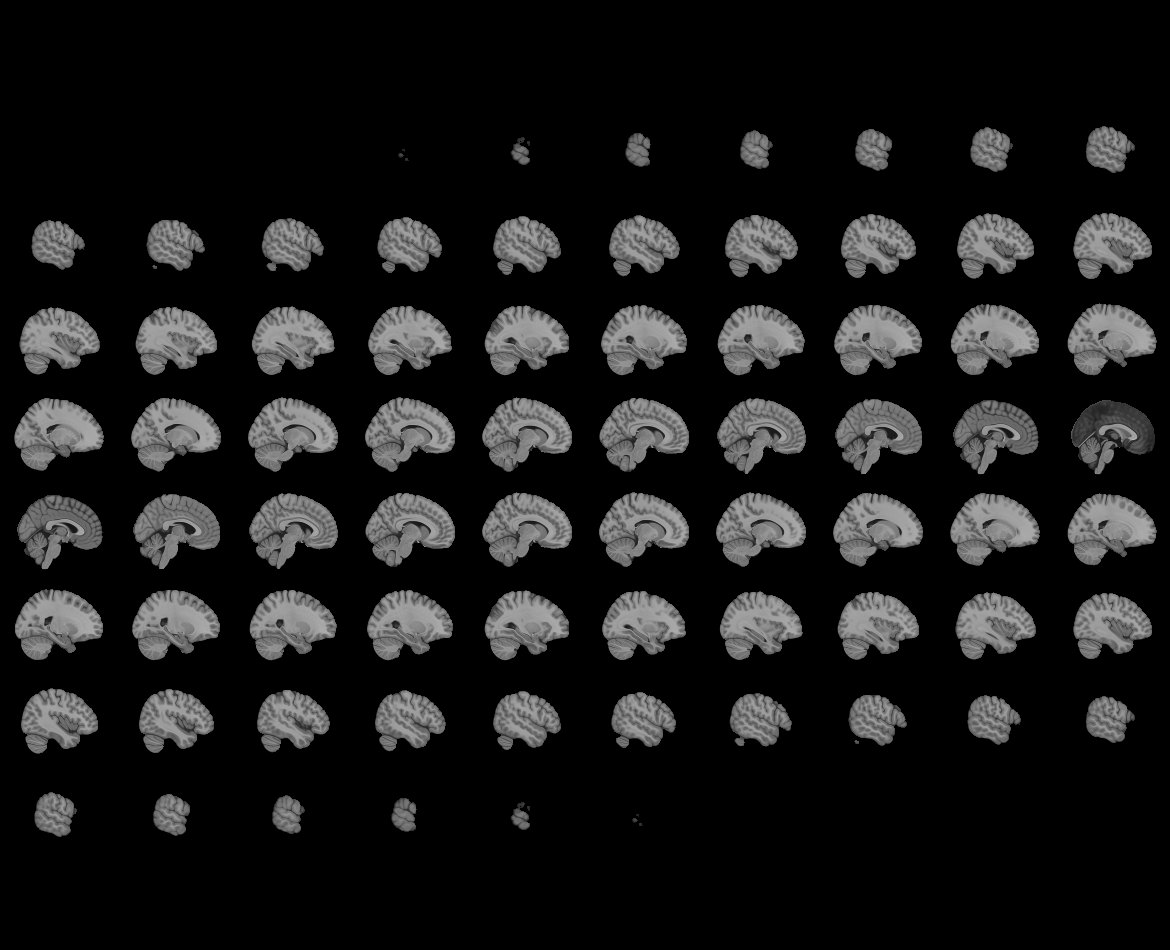
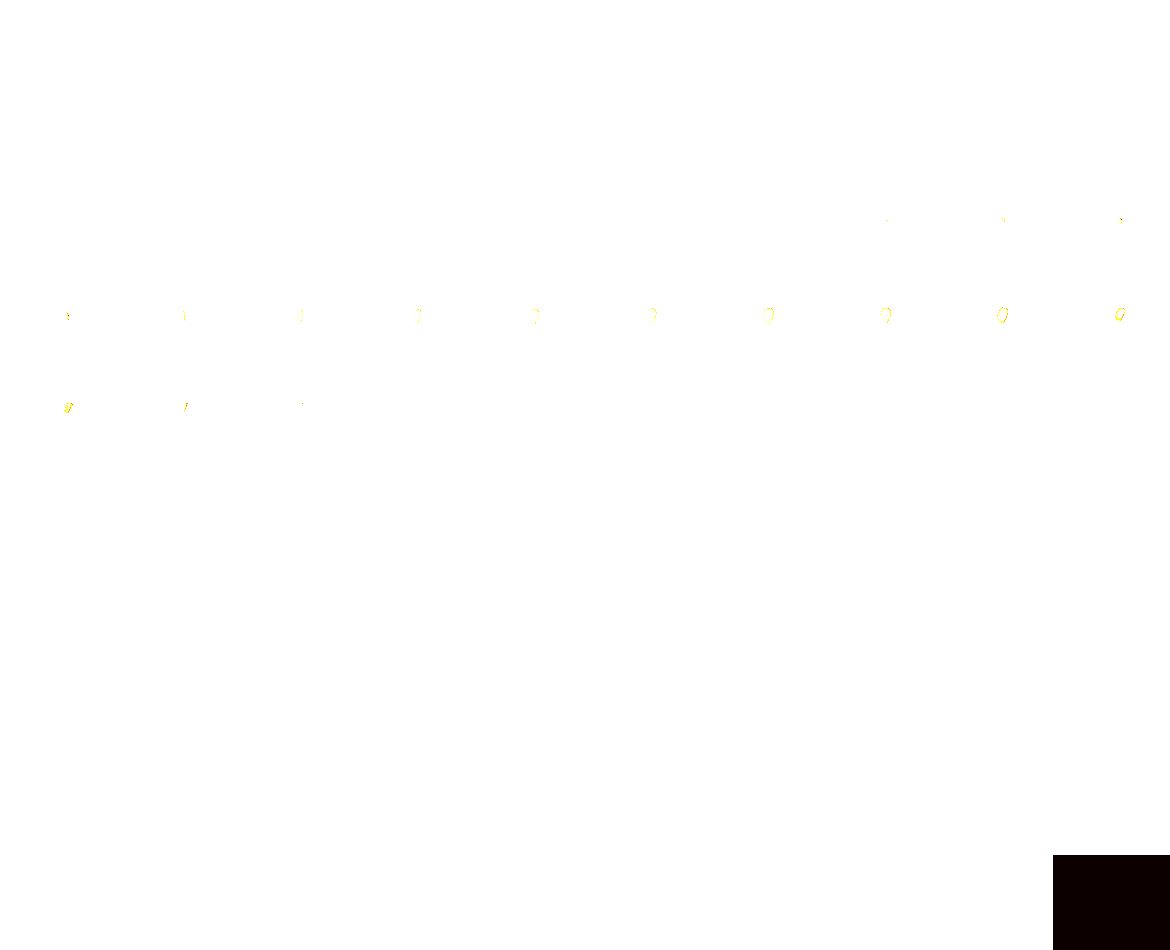

In [21]:
plotting.view_img(left_hemisphere_img)

### IFG, MFG and SFG from AAL, FEF from Wang (25%)

In [22]:
fef_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_FEF_lh_prob25.nii')
fef_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_FEF_rh_prob25.nii')
fef_wang = image.math_img("img1 + img2", img1=fef_lh_wang, img2=fef_rh_wang)

In [23]:
# superior frontal gyrus
sfg_lh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Sup_L.nii')
sfg_rh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Sup_R.nii')
sfg_aal = image.math_img("img1 + img2", img1=sfg_lh_aal, img2=sfg_rh_aal)

# middle frontal gyrus
mfg_lh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Mid_L.nii')
mfg_rh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Mid_R.nii')
mfg_aal = image.math_img("img1 + img2", img1=mfg_lh_aal, img2=mfg_rh_aal)

# inferior frontal gyrus
ifg_oper_lh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Inf_Oper_L.nii')
ifg_oper_rh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Inf_Oper_R.nii')
ifg_orb_lh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Inf_Orb_L.nii')
ifg_orb_rh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Inf_Orb_R.nii')
ifg_tri_lh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Inf_Tri_L.nii')
ifg_tri_rh_aal = nib.load('atlases/aal/separate_masks/2mm_Frontal_Inf_Tri_R.nii')
ifg_oper_aal = image.math_img("img1 + img2", img1=ifg_oper_lh_aal, img2=ifg_oper_rh_aal)
ifg_orb_aal = image.math_img("img1 + img2", img1=ifg_orb_lh_aal, img2=ifg_orb_rh_aal)
ifg_tri_aal = image.math_img("img1 + img2", img1=ifg_tri_lh_aal, img2=ifg_tri_rh_aal)
ifg_aal = image.math_img("img1 + img2 + img3", img1=ifg_oper_aal, img2=ifg_orb_aal, img3=ifg_tri_aal)

In [24]:
print(np.unique(fef_wang.get_fdata()))
print(np.unique(mfg_aal.get_fdata()))
# make sure images are binarized

[0. 1.]
[0. 1.]


In [25]:
mfg_aal = nilearn.image.binarize_img(mfg_aal)
sfg_aal = nilearn.image.binarize_img(sfg_aal)
ifg_aal = nilearn.image.binarize_img(ifg_aal)
fef_wang = nilearn.image.binarize_img(fef_wang)

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [91]:
# save ROI
nib.save(mfg_aal, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/mfg_aal.nii')
nib.save(sfg_aal, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/sfg_aal.nii')
nib.save(ifg_aal, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/ifg_aal.nii')
nib.save(fef_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/fef_wang_prob25.nii')

nib.save(fef_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/fef-wang25.nii')

# nib.save(img_dil_mfg, 'atlases/final_atlas_roi/dil_mfg_aal.nii')
# nib.save(img_dil_sfg, 'atlases/final_atlas_roi/dil_sfg_aal.nii')
# nib.save(img_dil_ifg, 'atlases/final_atlas_roi/dil_ifg_aal.nii')
# nib.save(img_dil_fef, 'atlases/final_atlas_roi/dil_fef_wang_prob25.nii')

In [27]:
# Left and right hemisphere
filenames = ['mfg_aal.nii','sfg_aal.nii','ifg_aal.nii','fef_wang_prob25.nii']

# Apply the masks to the data
masks = [mfg_aal,sfg_aal,ifg_aal,fef_wang]

for mask,file in zip(masks,filenames):
    left_data = np.where(left_mask, mask.get_fdata(), 0)
    right_data = np.where(right_mask, mask.get_fdata(), 0)

    # Create new NIfTI images for left and right hemispheres
    left_hemisphere_img = image.new_img_like(mask, left_data, affine)
    right_hemisphere_img = image.new_img_like(mask, right_data, affine)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'l-'+file)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'r-'+file)
    
nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/l-fef-wang25.nii')
nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/r-fef-wang25.nii')

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



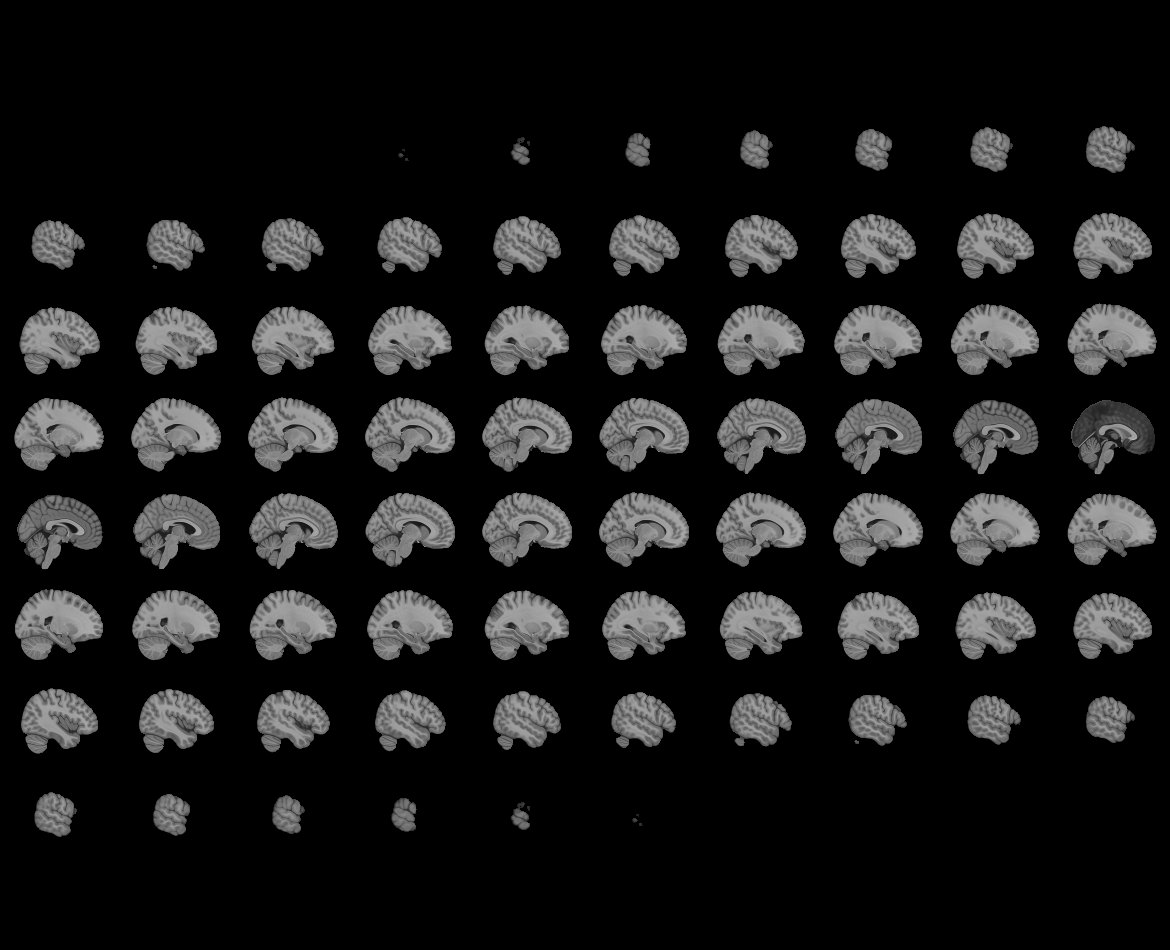
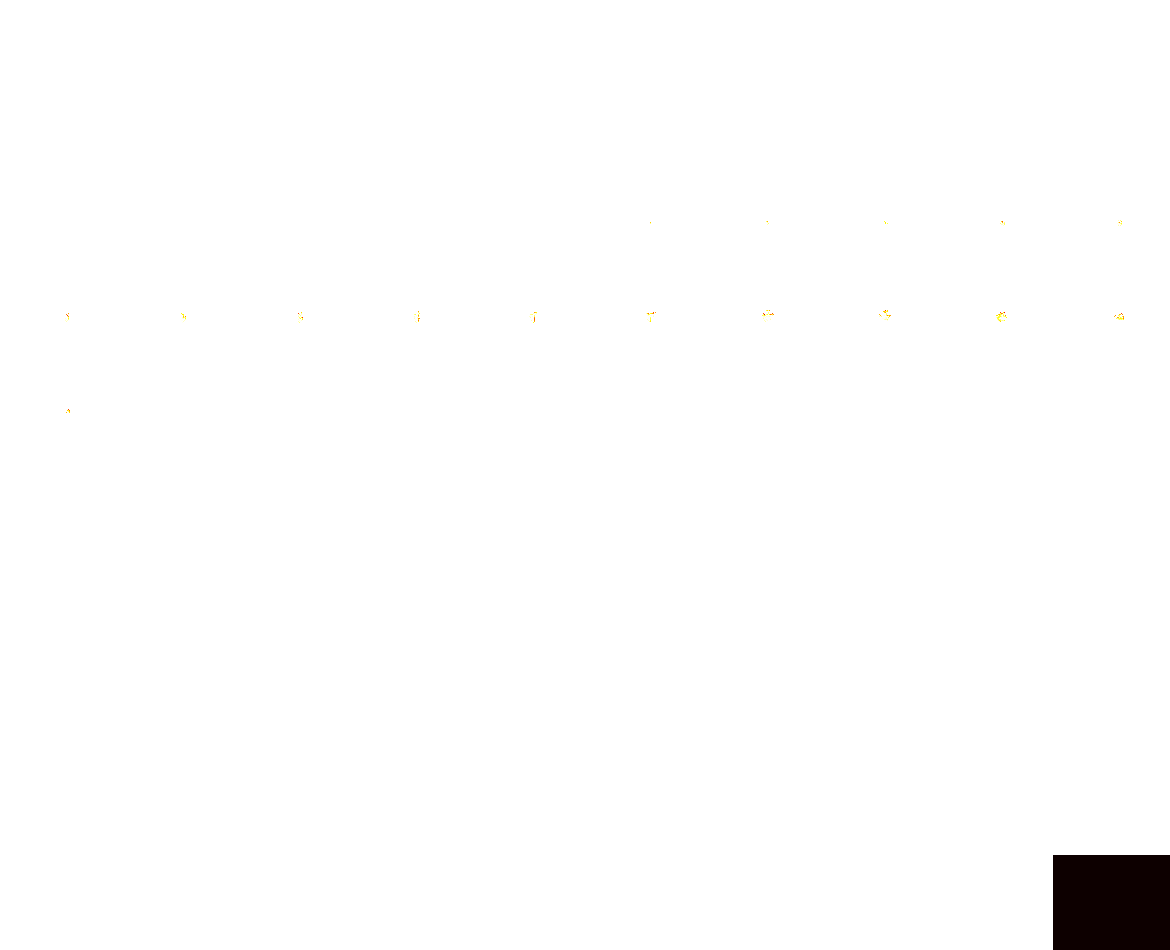

In [28]:
plotting.view_img(left_hemisphere_img)

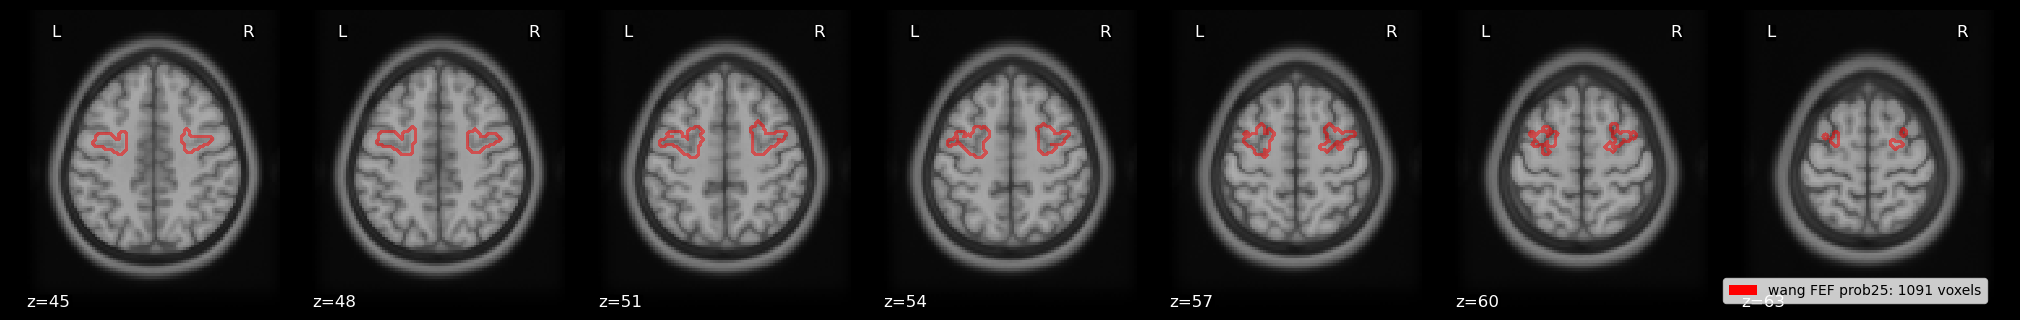

In [39]:
# plot ROI - FEF WANG

fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(45,65,3)), figure=fig
)
masks = [fef_wang]
num_vox = image.get_data(masks[0]).sum()
#masks = [img_dil_mfg,img_dil_sfg,img_dil_fef]
colors = ["red", "blue", "limegreen", "cyan"]

for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="cyan")
p5 = Rectangle((0,0), 1, 1, fc="purple")
plt.legend([p1, p2, p3, p4], 
           ["wang FEF prob25: "+str(num_vox)+" voxels"], 
           loc="lower right")
plt.show()

##### AAL plus FEF wang

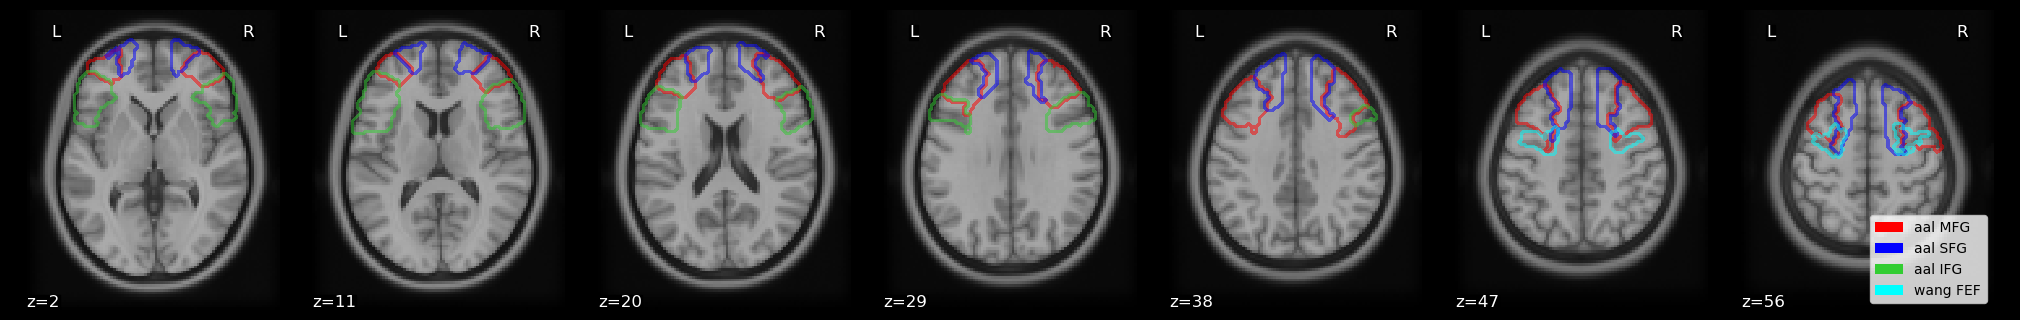

In [40]:
# plot ROI
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(2,65,9)), figure=fig
)
masks = [mfg_aal, sfg_aal, ifg_aal, fef_wang]
#masks = [img_dil_mfg,img_dil_sfg,img_dil_fef]
colors = ["red", "blue", "limegreen", "cyan"]

for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="cyan")
p5 = Rectangle((0,0), 1, 1, fc="purple")
plt.legend([p1, p2, p3, p4], 
           ["aal MFG", "aal SFG", "aal IFG", "wang FEF"], 
           loc="lower right")
plt.show()

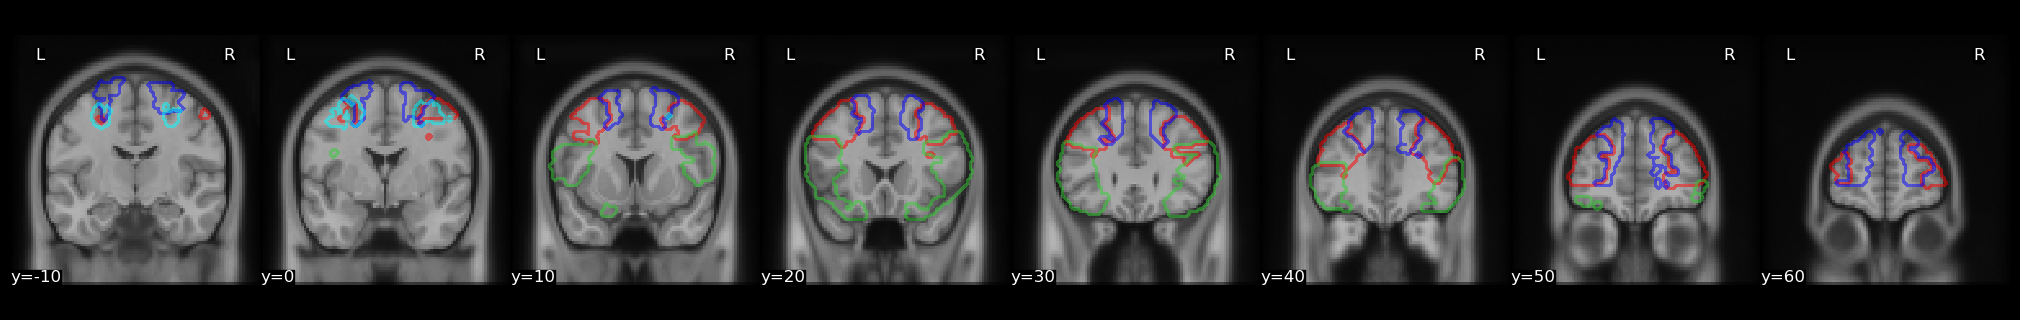

In [42]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="y", cut_coords=list(range(-10,65,10)), figure=fig
)
masks = [mfg_aal, sfg_aal, ifg_aal, fef_wang]
#masks = [img_dil_mfg,img_dil_sfg,img_dil_fef]
colors = ["red", "blue", "limegreen", "cyan"]

for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="cyan")
p5 = Rectangle((0,0), 1, 1, fc="purple")
# plt.legend([p1, p2, p3, p4], 
#            ["aal MFG", "aal SFG", "aal IFG","wang FEF"], 
#            loc="lower right")
plt.show()

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'contours', 'linewidth'
  im = getattr(ax, type)(data_2d.copy(),


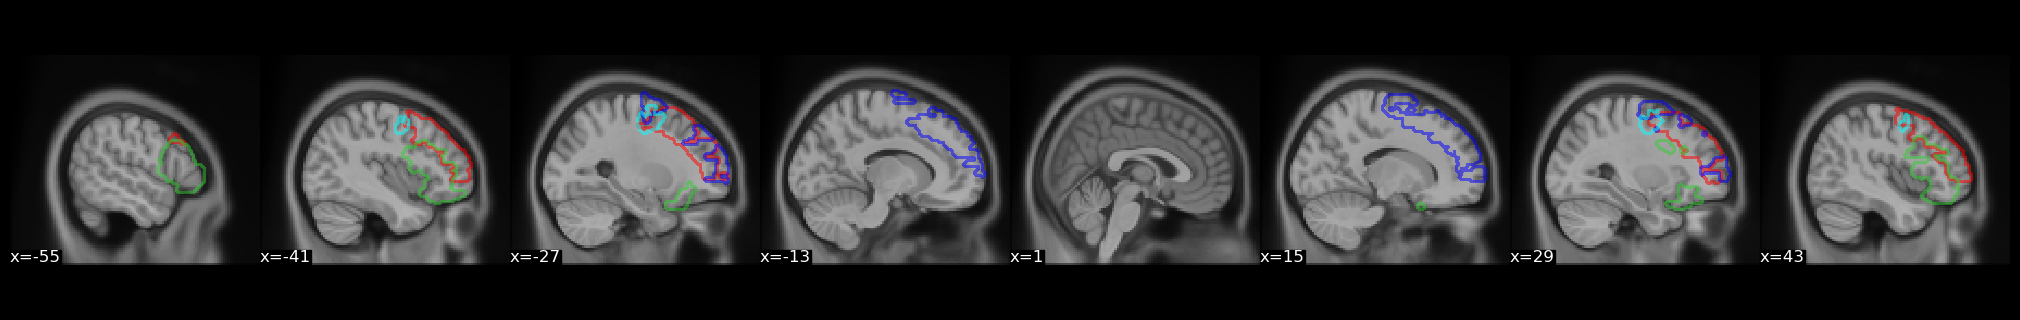

In [43]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="x", cut_coords=list(range(-55,57,14)), figure=fig
)
masks = [mfg_aal, sfg_aal, ifg_aal, fef_wang]
#masks = [img_dil_mfg,img_dil_sfg,img_dil_fef]
colors = ["red", "blue", "limegreen", "cyan"]

for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="cyan")
p5 = Rectangle((0,0), 1, 1, fc="purple")
# plt.legend([p1, p2, p3, p4, p5], 
#            ["julich (area 8v)", "hcp (area 9-46)", "aal (MFG)", "hcp (area 8)", "julich (frontal I)"], 
#            loc="best")

plt.show()

# HCP BA frontal areas

In [44]:
# load roi from hcp atlas
# frontal eye field
fef_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_FEF_L.nii')
fef_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_FEF_R.nii')
# premotor eye field, not parietal eye field
pef_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_PEF_L.nii')
pef_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_PEF_R.nii')

# sfg
sfl_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_SFL_L.nii')
sfl_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_SFL_R.nii')

area8bl_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8BL_L.nii')
area8bl_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8BL_R.nii')
area8ad_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8Ad_L.nii')
area8ad_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8Ad_R.nii')
area8av_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8Av_L.nii')
area8av_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8Av_R.nii')
area8c_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8C_L.nii')
area8c_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_8C_R.nii')

area9a_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_9a_L.nii')
area9a_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_9a_R.nii')
area9p_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_9p_L.nii')
area9p_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_9p_R.nii')

# mfg
area9_46d_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_9-46d_L.nii')
area9_46d_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_9-46d_R.nii')
a9_46v_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_a9-46v_L.nii')
a9_46v_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_a9-46v_R.nii')
p9_46v_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_p9-46v_L.nii')
p9_46v_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_p9-46v_R.nii')

# ifg: 44, 45, 47
area44_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_44_L.nii')
area44_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_44_R.nii')
area45_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_45_L.nii')
area45_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_45_R.nii')
area47l_lh_hcp = nib.load('atlases/HCP/separate_masks/2mm_47l_L.nii')
area47l_rh_hcp = nib.load('atlases/HCP/separate_masks/2mm_47l_R.nii')

# combine these images
fef_hcp = image.math_img("img1 + img2", img1=fef_lh_hcp, img2=fef_rh_hcp)
pef_hcp = image.math_img("img1 + img2", img1=pef_lh_hcp, img2=pef_rh_hcp)
fpef_hcp = image.math_img("img1 + img2", img1=fef_hcp, img2=pef_hcp)

sfl_hcp = image.math_img("img1 + img2", img1=sfl_lh_hcp, img2=sfl_rh_hcp)
area8_hcp = image.math_img("img1 + img2 + img3 + img4 + img5 + img6 + img7 + img8", 
                         img1=area8bl_lh_hcp, 
                         img2=area8bl_rh_hcp,
                        img3=area8ad_lh_hcp,
                         img4=area8ad_rh_hcp,
                         img5=area8av_lh_hcp,
                         img6=area8av_rh_hcp,
                          img7=area8c_lh_hcp,
                          img8=area8c_rh_hcp)

area9_hcp = image.math_img("img1 + img2 + img3 + img4", 
                         img1=area9a_lh_hcp, 
                         img2=area9a_rh_hcp,
                        img3=area9p_lh_hcp,
                         img4=area9p_rh_hcp)

area9_46_hcp = image.math_img("img1 + img2 + img3 + img4 + img5 + img6", 
                         img1=area9_46d_lh_hcp, 
                         img2=area9_46d_rh_hcp,
                        img3=a9_46v_lh_hcp,
                         img4=a9_46v_rh_hcp,
                         img5=p9_46v_lh_hcp,
                         img6=p9_46v_rh_hcp)

area44_45_47l_hcp = image.math_img("img1 + img2 + img3 + img4 + img5 + img6", 
                         img1=area44_lh_hcp, 
                         img2=area44_rh_hcp,
                        img3=area45_lh_hcp,
                         img4=area45_rh_hcp,
                         img5=area47l_lh_hcp,
                         img6=area47l_rh_hcp)

In [46]:
print(np.unique(area44_45_47l_hcp.get_fdata()))
print(np.unique(fef_hcp.get_fdata()))

[0. 1.]
[0. 1.]


In [92]:
area8_hcp = nilearn.image.binarize_img(area8_hcp)
area9_hcp = nilearn.image.binarize_img(area9_hcp)
area9_46_hcp = nilearn.image.binarize_img(area9_46_hcp)
area44_45_47l_hcp = nilearn.image.binarize_img(area44_45_47l_hcp)
fef_hcp = nilearn.image.binarize_img(fef_hcp)

In [93]:
# Save ROI

nib.save(area8_hcp, 'atlases/final_atlas_roi/rsa_atlas_roi/area8-hcp.nii')
nib.save(area9_hcp, 'atlases/final_atlas_roi/rsa_atlas_roi/area9-hcp.nii')
nib.save(area9_46_hcp, 'atlases/final_atlas_roi/rsa_atlas_roi/area9|46-hcp.nii')
nib.save(area44_45_47l_hcp, 'atlases/final_atlas_roi/rsa_atlas_roi/area44|45|47l-hcp.nii')
nib.save(fef_hcp, 'atlases/final_atlas_roi/rsa_atlas_roi/fef-hcp.nii')


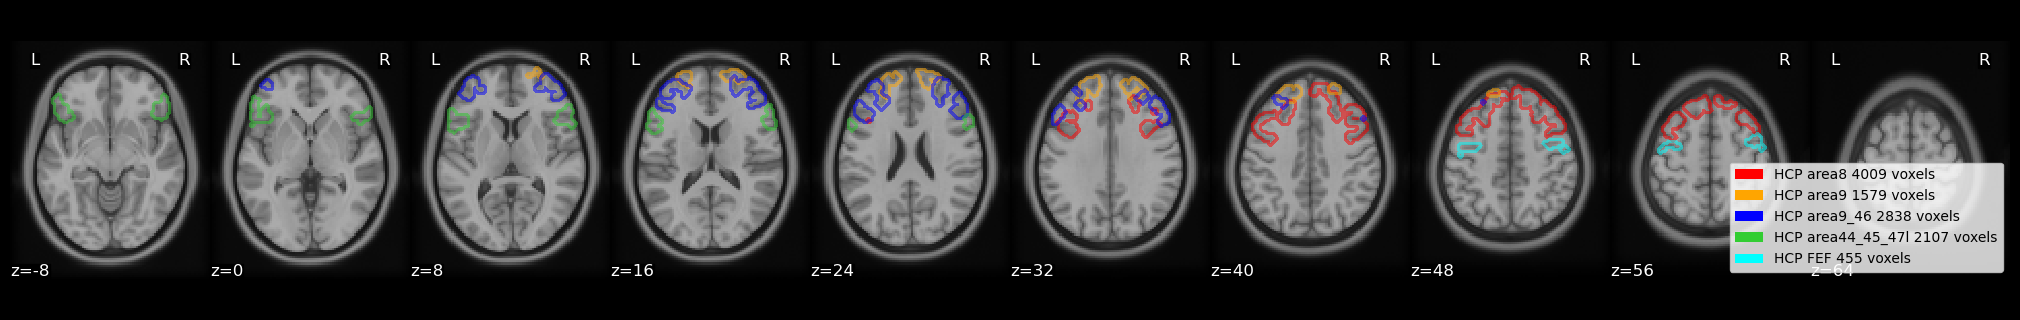

In [48]:
# Plot HCP
masks = [area8_hcp,area9_hcp,area9_46_hcp,area44_45_47l_hcp,fef_hcp] # #sfl_hcp

vox_num = []
for mask in masks:
    vox_num_1 = nilearn.image.get_data(mask).sum()
    vox_num.append(vox_num_1)
    
# plot ROI
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(-8,65,8)), figure=fig 
) #2,65,9
#masks = [mfg_aal, sfg_aal, ifg_aal, fef_wang]
#masks = [img_dil_mfg,img_dil_sfg,img_dil_fef]
colors = [ "red","orange","blue", "limegreen","cyan"] #  "red",   ,"purple" #, "cyan"

for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
#p1= Rectangle((0,0), 1, 1, fc=colors[0])
#p2 = Rectangle((0,0), 1, 1, fc=colors[0])
p1 = Rectangle((0,0), 1, 1, fc=colors[0])
p2 = Rectangle((0,0), 1, 1, fc=colors[1])
p3 = Rectangle((0,0), 1, 1, fc=colors[2])
p4 = Rectangle((0,0), 1, 1, fc=colors[3])
p5 = Rectangle((0,0), 1, 1, fc=colors[4])
plt.legend([p1,p2,p3,p4,p5],  #p1, p2, 
           ["HCP area8 "+str(vox_num[0])+" voxels",
            "HCP area9 "+str(vox_num[1])+" voxels",
            "HCP area9_46 "+str(vox_num[2])+" voxels",
            "HCP area44_45_47l "+str(vox_num[3])+" voxels",
            "HCP FEF "+str(vox_num[4])+" voxels"],  #
           loc="lower right") #"HCP sfl", 
plt.show()


# Parietal, wang atlas 15%

In [29]:
# load roi from wang atlas
ips0_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS0_lh_prob15.nii')
ips1_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS1_lh_prob15.nii')
ips2_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS2_lh_prob15.nii')
ips3_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS3_lh_prob15.nii')
ips4_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS4_lh_prob15.nii')
ips5_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS5_lh_prob15.nii')
spl1_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_SPL1_lh_prob15.nii')

ips0_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS0_rh_prob15.nii')
ips1_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS1_rh_prob15.nii')
ips2_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS2_rh_prob15.nii')
ips3_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS3_rh_prob15.nii')
ips4_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS4_rh_prob15.nii')
ips5_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_IPS5_rh_prob15.nii')
spl1_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_SPL1_rh_prob15.nii')

In [30]:
# we want to combine areas
ips0_wang = image.math_img("img1 + img2", img1=ips0_lh_wang,img2=ips0_rh_wang)
ips1_wang = image.math_img("img1 + img2", img1=ips1_lh_wang,img2=ips1_rh_wang)
ips2_wang = image.math_img("img1 + img2", img1=ips2_lh_wang,img2=ips2_rh_wang)
ips3_wang = image.math_img("img1 + img2", img1=ips3_lh_wang,img2=ips3_rh_wang)
ips4_wang = image.math_img("img1 + img2", img1=ips4_lh_wang,img2=ips4_rh_wang)
ips5_wang = image.math_img("img1 + img2", img1=ips5_lh_wang,img2=ips5_rh_wang)
spl1_wang = image.math_img("img1 + img2", img1=spl1_lh_wang,img2=spl1_rh_wang)

ips_lh_wang = image.math_img("img1+img2+img3+img4+img5+img6", 
                             img1=ips0_lh_wang,img2=ips1_lh_wang,
                            img3=ips2_lh_wang,img4=ips3_lh_wang,
                            img5=ips4_lh_wang,img6=ips5_lh_wang)
ips_rh_wang = image.math_img("img1+img2+img3+img4+img5+img6", 
                             img1=ips0_rh_wang,img2=ips1_rh_wang,
                            img3=ips2_rh_wang,img4=ips3_rh_wang,
                            img5=ips4_rh_wang,img6=ips5_rh_wang)
ips_wang = image.math_img("img1 + img2", img1=ips_lh_wang,img2=ips_rh_wang)
spl1_wang = image.math_img("img1 + img2", img1=spl1_lh_wang, img2=spl1_rh_wang)

ips012_lh_wang = image.math_img("img1+img2+img3", 
                             img1=ips0_lh_wang,img2=ips1_lh_wang,
                            img3=ips2_lh_wang)
ips345_lh_wang = image.math_img("img1+img2+img3", 
                             img1=ips3_lh_wang,img2=ips4_lh_wang,
                            img3=ips5_lh_wang)
ips012_rh_wang = image.math_img("img1+img2+img3", 
                             img1=ips0_rh_wang,img2=ips1_rh_wang,
                            img3=ips2_rh_wang)
ips345_rh_wang = image.math_img("img1+img2+img3", 
                             img1=ips3_rh_wang,img2=ips4_rh_wang,
                            img3=ips5_rh_wang)
ips012_wang = image.math_img("img1 + img2", img1=ips012_lh_wang,img2=ips012_rh_wang)
ips345_wang = image.math_img("img1 + img2", img1=ips345_lh_wang,img2=ips345_rh_wang)

ips012spl1_wang = image.math_img("img1 + img2", img1=ips012_wang,img2=spl1_wang)

lparietal_wang = image.math_img("img1 + img2", img1=ips_wang,img2=spl1_wang)

In [31]:
print(np.unique(lparietal_wang.get_fdata()))
print(np.unique(spl1_wang.get_fdata()))

[0. 1. 2. 3.]
[0. 1.]


In [32]:
# binarize all images
lparietal_wang = nilearn.image.binarize_img(lparietal_wang)
ips0_wang = nilearn.image.binarize_img(ips0_wang)
ips1_wang = nilearn.image.binarize_img(ips1_wang)
ips2_wang = nilearn.image.binarize_img(ips2_wang)
ips3_wang = nilearn.image.binarize_img(ips3_wang)
ips4_wang = nilearn.image.binarize_img(ips4_wang)
ips5_wang = nilearn.image.binarize_img(ips5_wang)
spl1_wang = nilearn.image.binarize_img(spl1_wang)

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [33]:
print(np.unique(lparietal_wang.get_fdata()))
print(np.unique(spl1_wang.get_fdata()))

[0. 1.]
[0. 1.]


In [69]:
nib.save(lparietal_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/lparietal_wang_prob15.nii')
nib.save(ips0_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/ips0_wang_prob15.nii')
nib.save(ips1_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/ips1_wang_prob15.nii')
nib.save(ips2_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/ips2_wang_prob15.nii')
nib.save(ips3_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/ips3_wang_prob15.nii')
nib.save(ips4_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/ips4_wang_prob15.nii')
nib.save(ips5_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/ips5_wang_prob15.nii')
nib.save(spl1_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/spl1_wang_prob15.nii')

nib.save(lparietal_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/ips-wang15.nii')
nib.save(ips0_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/ips0-wang15.nii')
nib.save(ips1_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/ips1-wang15.nii')
nib.save(ips2_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/ips2-wang15.nii')
nib.save(ips3_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/ips3-wang15.nii')
nib.save(ips4_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/ips4-wang15.nii')
nib.save(ips5_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/ips5-wang15.nii')
nib.save(spl1_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/spl1-wang15.nii')



In [34]:
# Left and right hemisphere
filenames1 = ['lparietal_wang_prob15.nii','ips0_wang_prob15.nii','ips1_wang_prob15.nii','ips2_wang_prob15.nii',
             'ips3_wang_prob15.nii','ips4_wang_prob15.nii','ips5_wang_prob15.nii','spl1_wang_prob15.nii']
filenames2 = ['ips-wang15.nii','ips0-wang15.nii','ips1-wang15.nii','ips2-wang15.nii',
             'ips3-wang15.nii','ips4-wang15.nii','ips5-wang15.nii','spl1-wang15.nii']

# Apply the masks to the data
masks = [lparietal_wang,ips0_wang,ips1_wang,ips2_wang,ips3_wang,ips4_wang,ips5_wang,spl1_wang]

for mask,file1,file2 in zip(masks,filenames1,filenames2):
    left_data = np.where(left_mask, mask.get_fdata(), 0)
    right_data = np.where(right_mask, mask.get_fdata(), 0)

    # Create new NIfTI images for left and right hemispheres
    left_hemisphere_img = image.new_img_like(mask, left_data, affine)
    right_hemisphere_img = image.new_img_like(mask, right_data, affine)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'l-'+file1)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'r-'+file1)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'l-'+file2)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'r-'+file2)

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



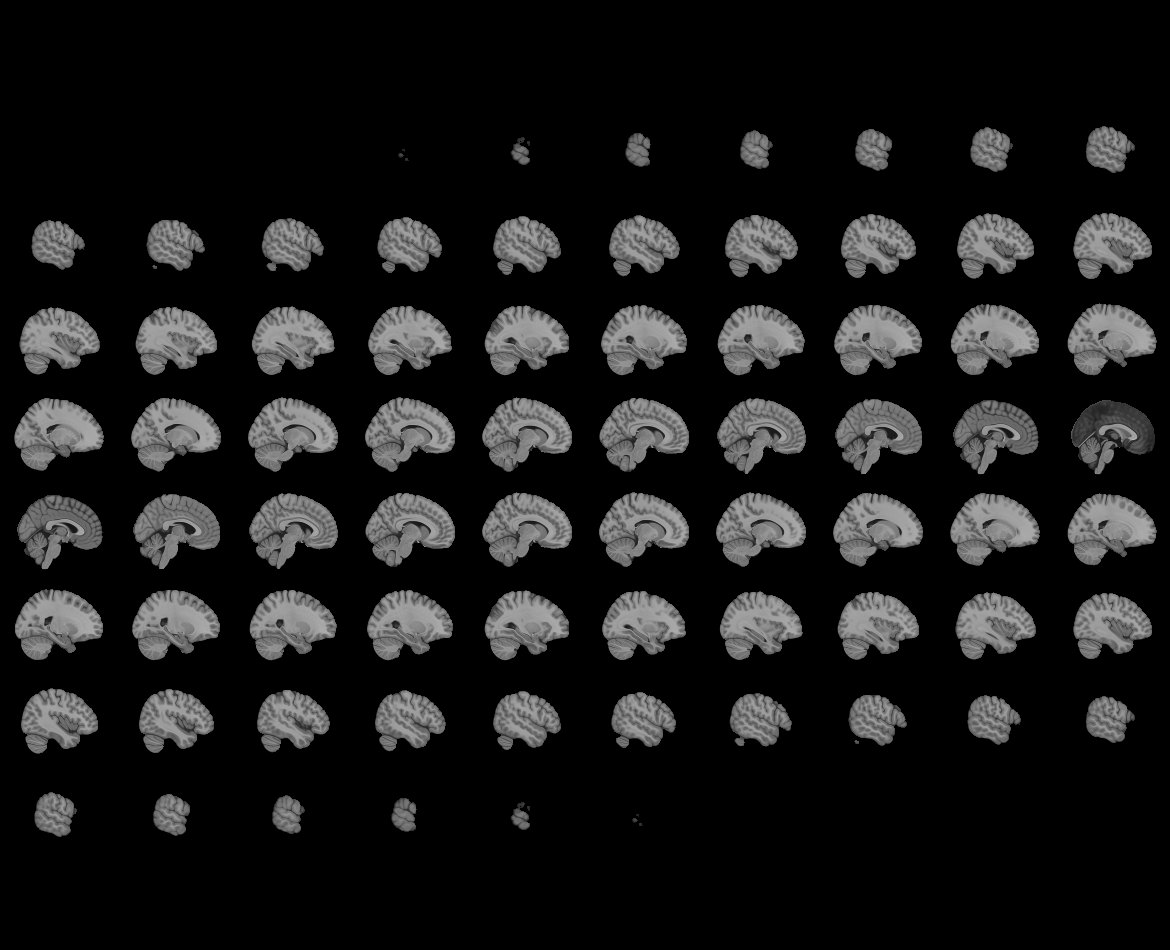
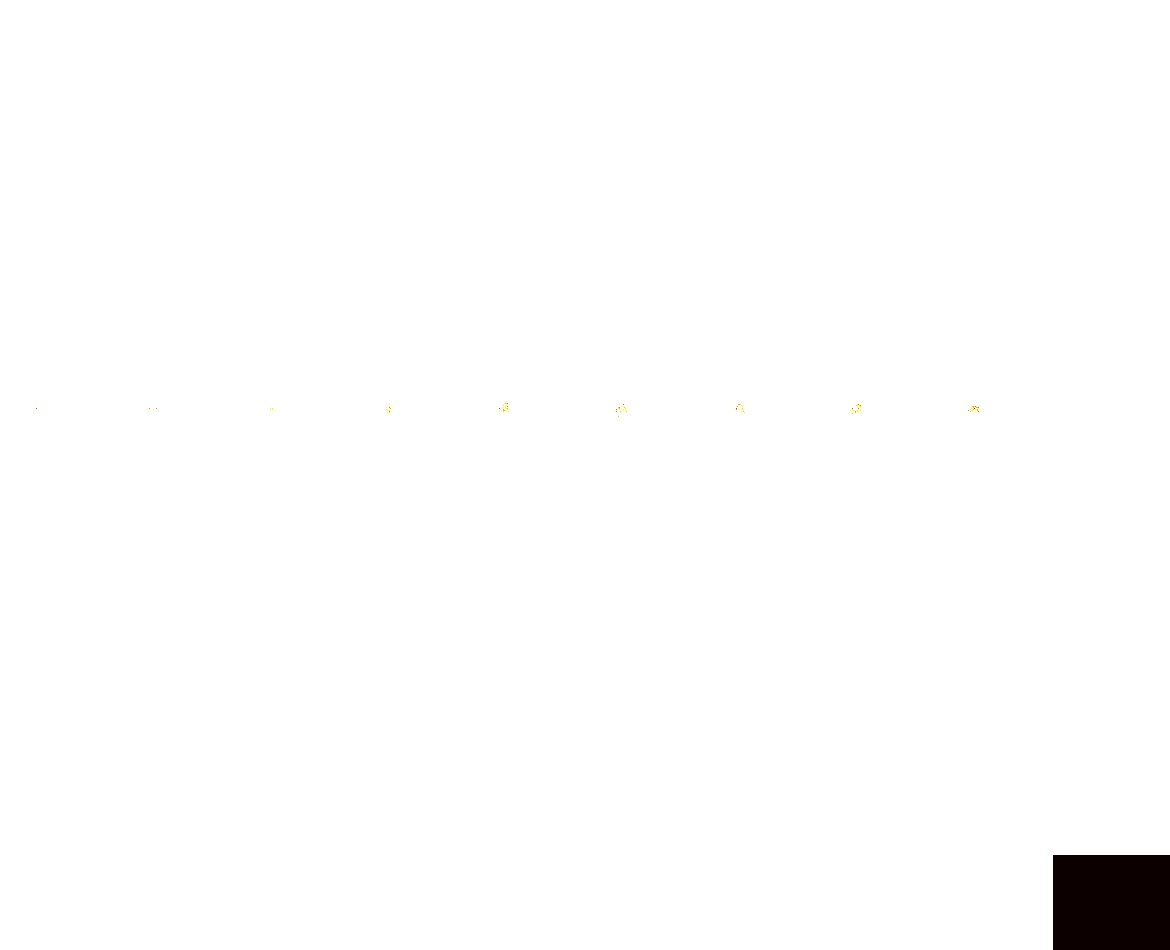

In [35]:
plotting.view_img(left_hemisphere_img)

In [36]:
print('Number of overlapping voxels: \n'+
'between ips0 and ips1: ' +str(image.get_data(image.math_img('img1 & img2',img1=ips0_wang,img2=ips1_wang)).sum())
      +'\n'+
'between ips1 and ips2: '+str(image.get_data(image.math_img('img1 & img2',img1=ips1_wang,img2=ips2_wang)).sum())
      +'\n'+
'between ips2 and ips3: '+str(image.get_data(image.math_img('img1 & img2',img1=ips2_wang,img2=ips3_wang)).sum())
      +'\n'+
'between ips3 and ips4: '+str(image.get_data(image.math_img('img1 & img2',img1=ips3_wang,img2=ips4_wang)).sum())
      +'\n'+
'between ips4 and ips5: '+str(image.get_data(image.math_img('img1 & img2',img1=ips4_wang,img2=ips5_wang)).sum())
      +'\n'+
'between ips5 and spl1: '+str(image.get_data(image.math_img('img1 & img2',img1=ips5_wang,img2=spl1_wang)).sum())
      +'\n')

Number of overlapping voxels: 
between ips0 and ips1: 470
between ips1 and ips2: 252
between ips2 and ips3: 94
between ips3 and ips4: 121
between ips4 and ips5: 124
between ips5 and spl1: 0



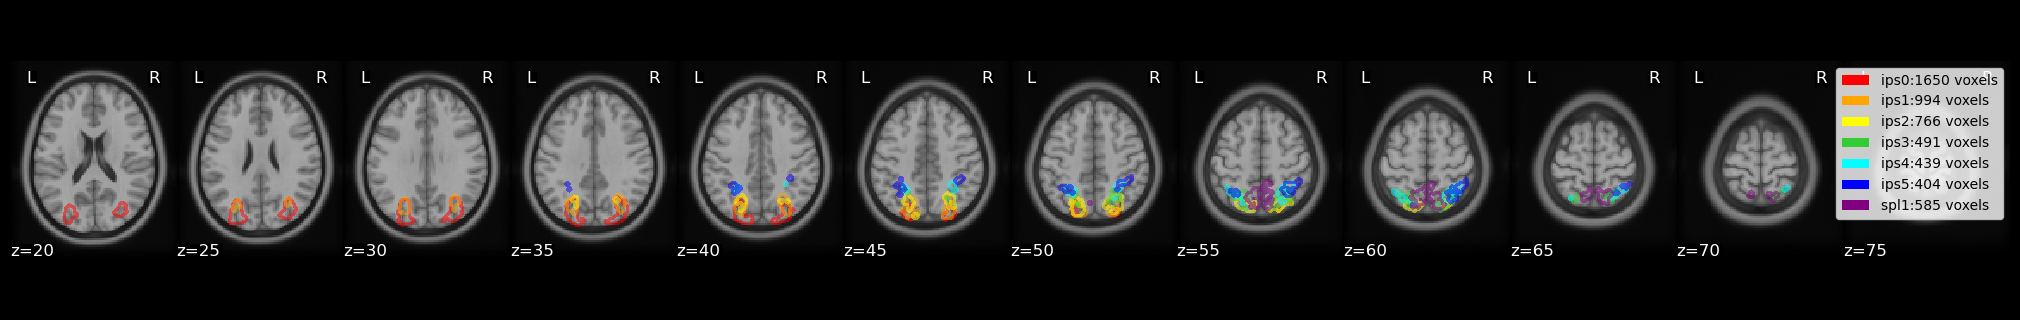

In [71]:
# plot these ROIs onto the brain
masks = [ips0_wang,ips1_wang,ips2_wang,ips3_wang,ips4_wang,ips5_wang,spl1_wang]#, spl1_wang]
vox_num = []
for mask in masks:
    vox_num_1 = nilearn.image.get_data(mask).sum()
    vox_num.append(vox_num_1)
    
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(20,80,5)), figure=fig
)

colors = ["red","orange","yellow","limegreen","cyan","blue","purple"]#, "limegreen"] #,'orange'
p = []
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
    p.append(Rectangle((0,0), 1, 1, fc=color))

plt.legend([p[0],p[1],p[2],p[3],p[4],p[5],p[6]], 
           ["ips0:"+str(vox_num[0])+" voxels",
            "ips1:"+str(vox_num[1])+" voxels",
            "ips2:"+str(vox_num[2])+" voxels",
            "ips3:"+str(vox_num[3])+" voxels",
            "ips4:"+str(vox_num[4])+" voxels",
            "ips5:"+str(vox_num[5])+" voxels",
            "spl1:"+str(vox_num[6])+" voxels"], loc="best") #, "wang spl" , p3

plt.show()

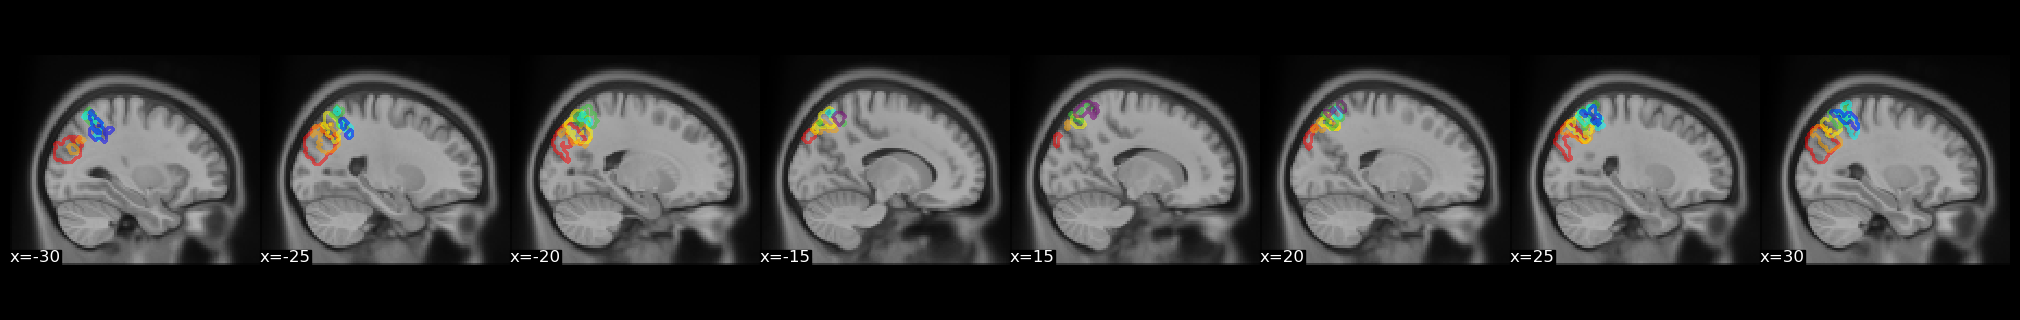

In [72]:
# plot these ROIs onto the brain
masks = [ips0_wang,ips1_wang,ips2_wang,ips3_wang,ips4_wang,ips5_wang,spl1_wang]#, spl1_wang]
    
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="x", cut_coords=[-30,-25,-20,-15,15,20,25,30], figure=fig
)

colors = ["red","orange","yellow","limegreen","cyan","blue","purple"]#, "limegreen"] #,'orange'
p = []
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
    p.append(Rectangle((0,0), 1, 1, fc=color))

plt.show()

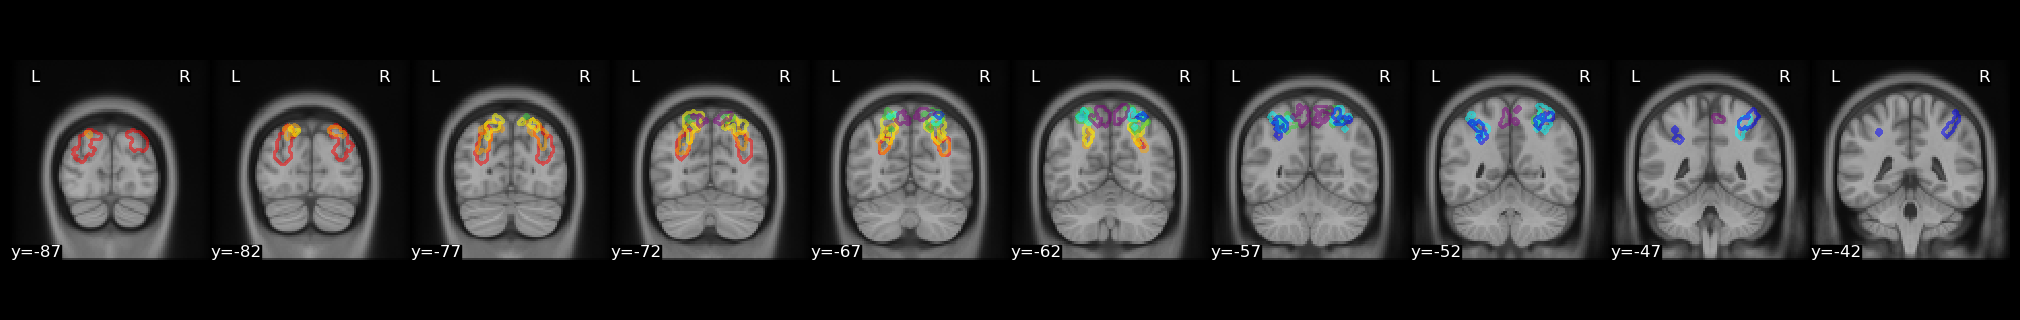

In [73]:
# plot these ROIs onto the brain
masks = [ips0_wang,ips1_wang,ips2_wang,ips3_wang,ips4_wang,ips5_wang,spl1_wang]#, spl1_wang]

fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="y", cut_coords=list(range(-87,-40,5)), figure=fig
)

colors = ["red","orange","yellow","limegreen","cyan","blue","purple"]#, "limegreen"] #,'orange'
p = []
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
    p.append(Rectangle((0,0), 1, 1, fc=color))

plt.show()

### V1 & V2 from Wang (25%), hOC1 & hOC2 from Julich (50%)

In [37]:
# load roi from wang atlas
v1v_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1v_lh_prob25.nii')
v1d_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1d_lh_prob25.nii')
v1v_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1v_rh_prob25.nii')
v1d_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1d_rh_prob25.nii')

# we want to combine v1v and v1d for the wang atlas
v1_lh_wang = image.math_img("img1 + img2", img1=v1v_lh_wang,img2=v1d_lh_wang)
v1_rh_wang = image.math_img("img1 + img2", img1=v1v_rh_wang,img2=v1d_rh_wang)
v1_wang = image.math_img("img1 + img2", img1=v1_lh_wang, img2=v1_rh_wang)

In [38]:
# load roi from wang atlas
v2v_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2v_lh_prob25.nii')
v2d_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2d_lh_prob25.nii')
v2v_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2v_rh_prob25.nii')
v2d_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2d_rh_prob25.nii')

# we want to combine v1v and v1d for the wang atlas
v2_lh_wang = image.math_img("img1 + img2", img1=v2v_lh_wang,img2=v2d_lh_wang)
v2_rh_wang = image.math_img("img1 + img2", img1=v2v_rh_wang,img2=v2d_rh_wang)
v2_wang = image.math_img("img1 + img2", img1=v2_lh_wang, img2=v2_rh_wang)

In [39]:
print(np.unique(v1_wang.get_fdata()))

[0. 1. 2.]


In [40]:
v1_wang = nilearn.image.binarize_img(v1_wang)
v2_wang = nilearn.image.binarize_img(v2_wang)

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [41]:
print(np.unique(v1_wang.get_fdata()))

[0. 1.]


In [77]:
# save ROIs
nib.save(v1_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/v1_wang_prob25.nii')
nib.save(v2_wang, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/v2_wang_prob25.nii')

nib.save(v1_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/v1-wang25.nii')
nib.save(v2_wang, 'atlases/final_atlas_roi/rsa_atlas_roi/v2-wang25.nii')

In [42]:
# Left and right hemisphere
filenames1 = ['v1_wang_prob25.nii','v2_wang_prob25.nii']
filenames2 = ['v1-wang25.nii','v2-wang25.nii']

# Apply the masks to the data
masks = [v1_wang,v2_wang]
affine = masks[0].affine

for mask,file1,file2 in zip(masks,filenames1,filenames2):
    left_data = np.where(left_mask, mask.get_fdata(), 0)
    right_data = np.where(right_mask, mask.get_fdata(), 0)

    # Create new NIfTI images for left and right hemispheres
    left_hemisphere_img = image.new_img_like(mask, left_data, affine)
    right_hemisphere_img = image.new_img_like(mask, right_data, affine)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'l-'+file1)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'r-'+file1)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'l-'+file2)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'r-'+file2)

plotting.view_img(left_hemisphere_img)

In [ ]:
# v1v_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1v_lh_prob50.nii')
# v1d_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1d_lh_prob50.nii')
# v1v_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1v_rh_prob50.nii')
# v1d_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V1d_rh_prob50.nii')

# v2v_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2v_lh_prob50.nii')
# v2d_lh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2d_lh_prob50.nii')
# v2v_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2v_rh_prob50.nii')
# v2d_rh_wang = nib.load('atlases/VisualProbAtlas_v4/subj_vol_all/2mm_V2d_rh_prob50.nii')

# # we want to combine v1v and v1d for the wang atlas
# v1_lh_wang = image.math_img("img1 + img2", img1=v1v_lh_wang,img2=v1d_lh_wang)
# v1_rh_wang = image.math_img("img1 + img2", img1=v1v_rh_wang,img2=v1d_rh_wang)
# v1_wang = image.math_img("img1 + img2", img1=v1_lh_wang, img2=v1_rh_wang)

# # we want to combine v1v and v1d for the wang atlas
# v2_lh_wang = image.math_img("img1 + img2", img1=v2v_lh_wang,img2=v2d_lh_wang)
# v2_rh_wang = image.math_img("img1 + img2", img1=v2v_rh_wang,img2=v2d_rh_wang)
# v2_wang = image.math_img("img1 + img2", img1=v2_lh_wang, img2=v2_rh_wang)

In [79]:
print('Number of overlapping voxels: \n'+
'between v1 and v2: ' +str(image.get_data(image.math_img('img1 & img2',img1=v1_wang,img2=v2_wang)).sum()))

Number of overlapping voxels: 
between v1 and v2: 329


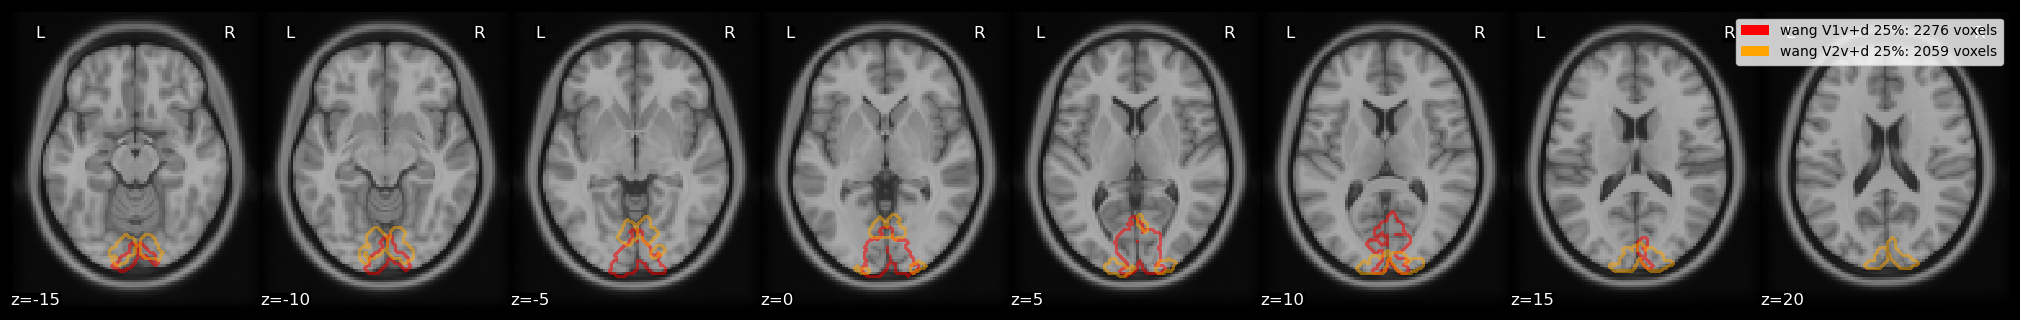

In [78]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(-15,25,5)), figure=fig
)
masks = [v1_wang, v2_wang]

num_vox = []
for mask in masks:
    num_vox.append(image.get_data(mask).sum())
    
colors = ["red",'orange']
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="orange")
plt.legend([p1, p4], ["wang V1v+d 25%: "+str(num_vox[0])+" voxels",
                      "wang V2v+d 25%: "+str(num_vox[1])+" voxels"], loc="best")

plt.show()

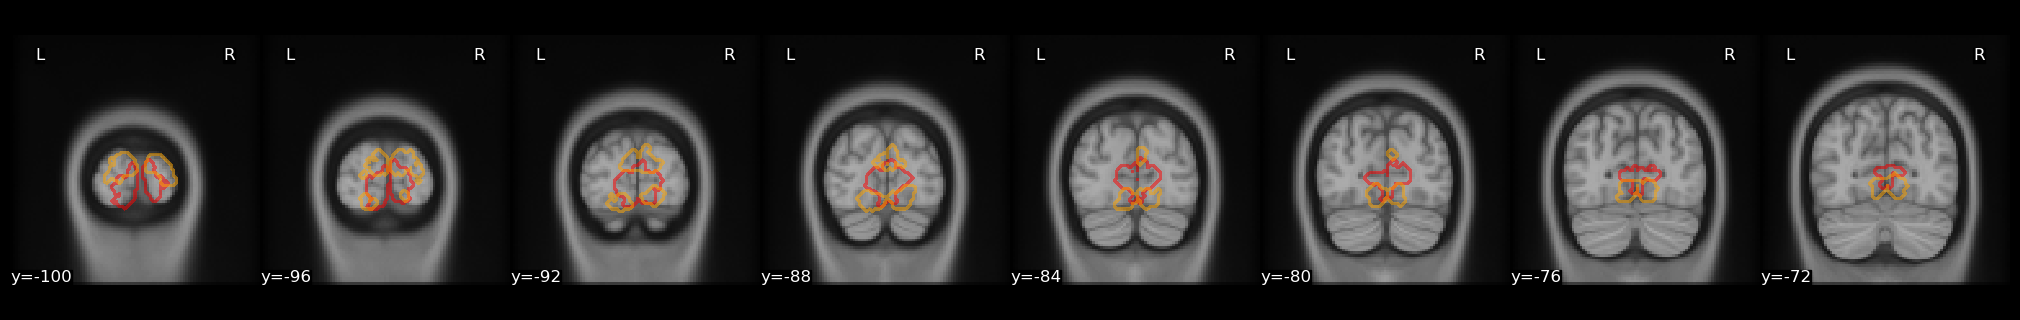

In [80]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="y", cut_coords=list(range(-100,-70,4)), figure=fig
)
masks = [v1_wang, v2_wang]
colors = ["red",'orange']
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="orange")
#plt.legend([p1, p2, p3, p4], ["julich hOc1 50%", "hcp V1", "aal V1", "wang V1v+d 50%"], loc="best")

plt.show()

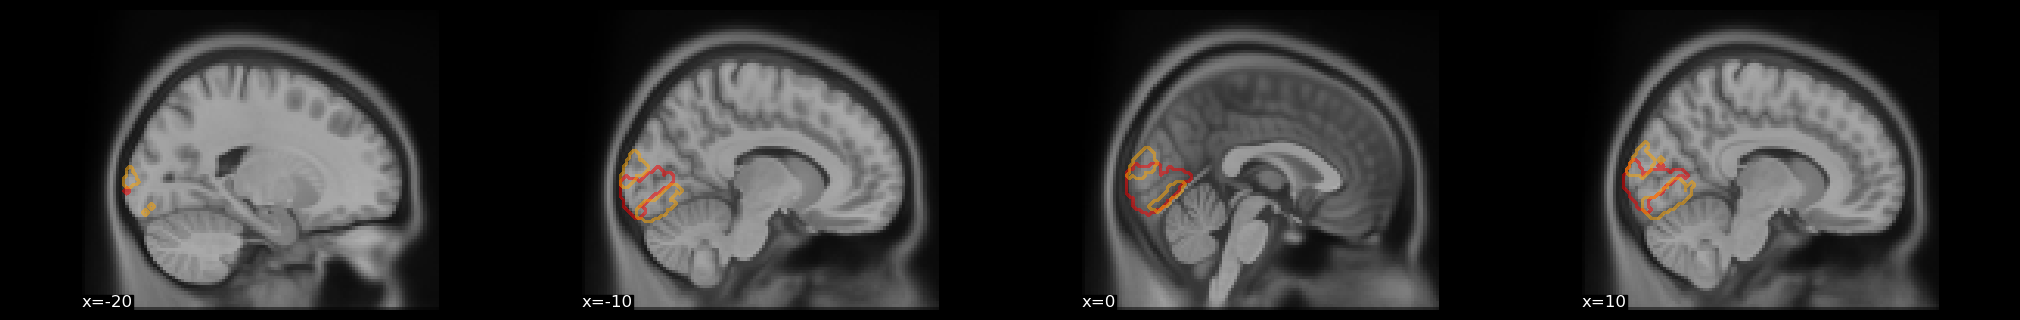

In [81]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="x", cut_coords=list(range(-20,20,10)), figure=fig
)
masks = [v1_wang, v2_wang]
colors = ["red",'orange']
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="orange")
#plt.legend([p1, p2, p3, p4], ["julich hOc1 50%", "hcp V1", "aal V1", "wang V1v+d 50%"], loc="best")

plt.show()

### primary motor cortex Julich 50%

In [44]:
# load roi from jubrain atlas
# primary motor cortex
area4a_lh_ju  = nib.load('atlases/jubrain/separate_masks/2mm_Area 4a (PreCG) left_prob50.nii')
area4a_rh_ju  = nib.load('atlases/jubrain/separate_masks/2mm_Area 4a (PreCG) right_prob50.nii')
area4p_lh_ju  = nib.load('atlases/jubrain/separate_masks/2mm_Area 4p (PreCG) left_prob50.nii')
area4p_rh_ju  = nib.load('atlases/jubrain/separate_masks/2mm_Area 4p (PreCG) right_prob50.nii')

area4_ju = image.math_img("img1+img2+img3+img4",
                        img1=area4a_lh_ju, img2=area4a_rh_ju,
                        img3=area4p_lh_ju, img4=area4p_rh_ju)

In [45]:
print(np.unique(area4_ju.get_fdata()))

[ 0.  1. nan]


In [46]:
area4_ju = nilearn.image.binarize_img(area4_ju)


/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [47]:
print(np.unique(area4_ju.get_fdata()))

[0. 1.]


In [86]:

nib.save(area4_ju, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/area4_ju_prob50.nii')

nib.save(area4_ju, 'atlases/final_atlas_roi/rsa_atlas_roi/area4-ju50.nii')


/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



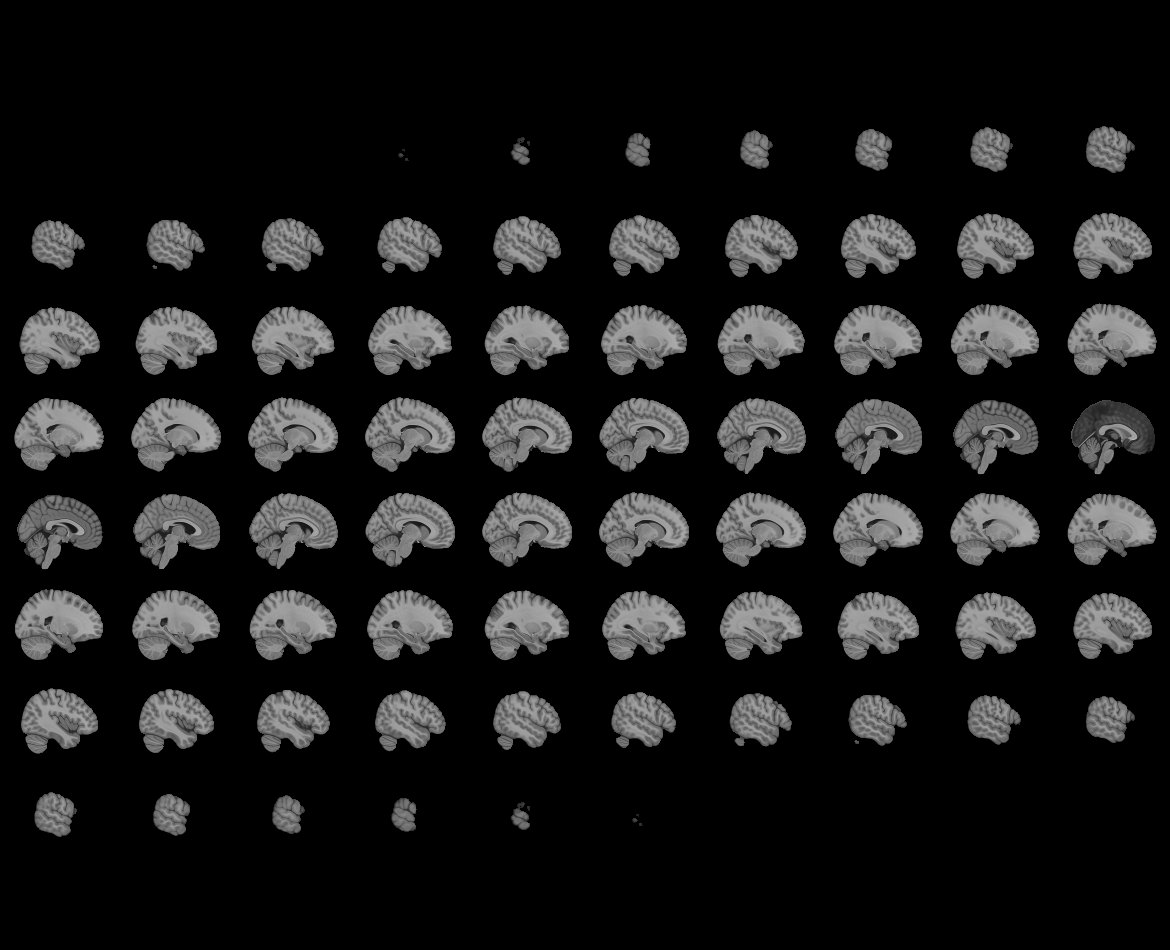
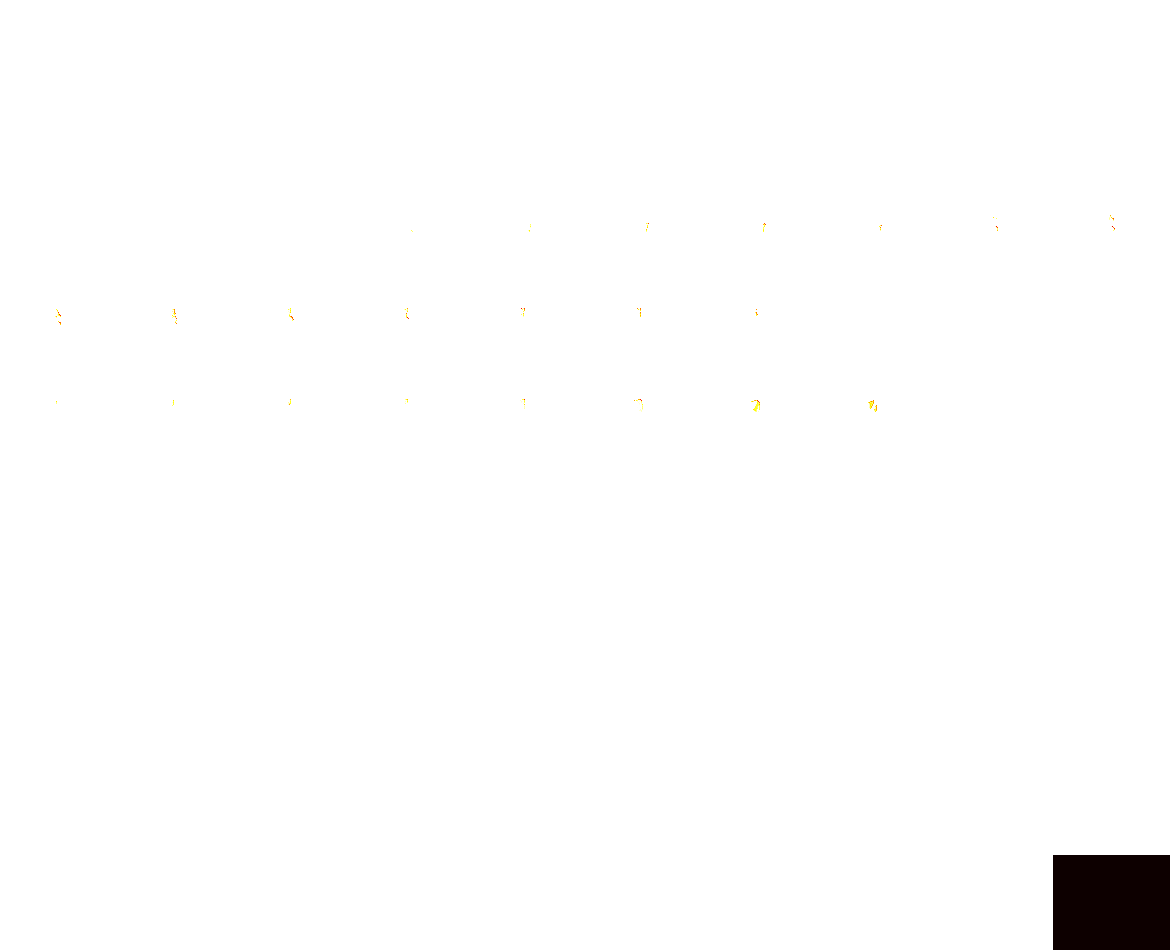

In [48]:
# Left and right hemisphere
filenames1 = ['area4_ju_prob50.nii']
filenames2 = ['area4-ju50.nii']

# Apply the masks to the data
masks = [area4_ju]
affine = masks[0].affine

for mask,file1,file2 in zip(masks,filenames1,filenames2):
    left_data = np.where(left_mask, mask.get_fdata(), 0)
    right_data = np.where(right_mask, mask.get_fdata(), 0)

    # Create new NIfTI images for left and right hemispheres
    left_hemisphere_img = image.new_img_like(mask, left_data, affine)
    right_hemisphere_img = image.new_img_like(mask, right_data, affine)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'l-'+file1)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/atlas_roi_for_func_overlap/'+'r-'+file1)
    
    nib.save(left_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'l-'+file2)
    nib.save(right_hemisphere_img, 'atlases/final_atlas_roi/rsa_atlas_roi/'+'r-'+file2)

plotting.view_img(left_hemisphere_img)

/gpfs/home/linjjiang/.local/lib/python3.11/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'contours', 'linewidth'
  im = getattr(ax, type)(data_2d.copy(),


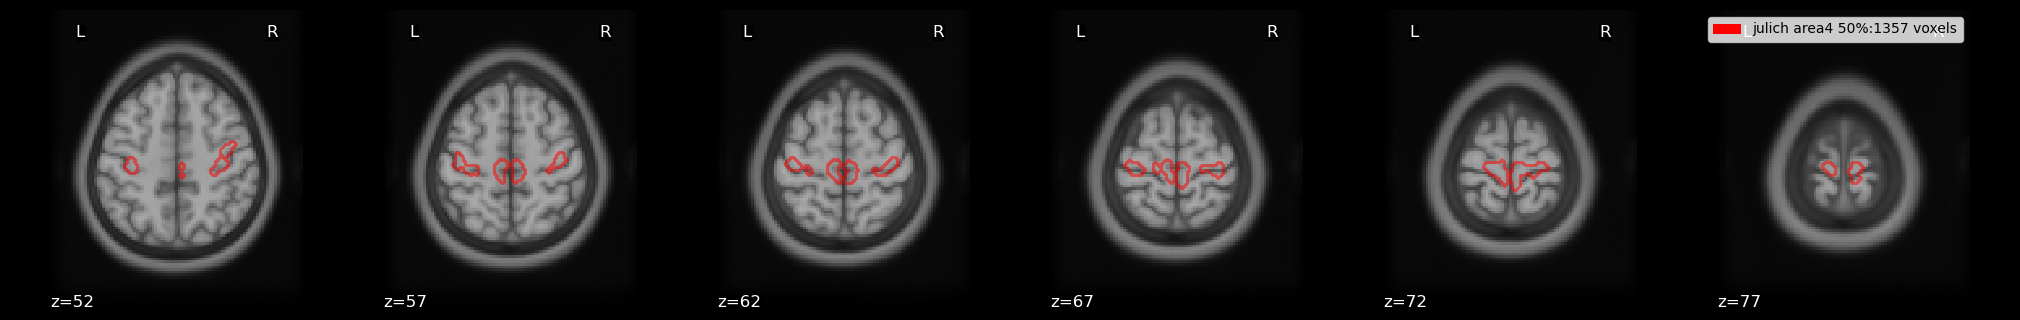

In [49]:
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(52,82,5)), figure=fig
)
masks = [area4_ju]
num_vox = image.get_data(area4_ju).sum()

colors = ["red", "blue", "limegreen",'orange']
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="orange")
plt.legend([p1], ["julich area4 50%:"+str(num_vox.astype(int))+" voxels"], loc="best")

plt.show()

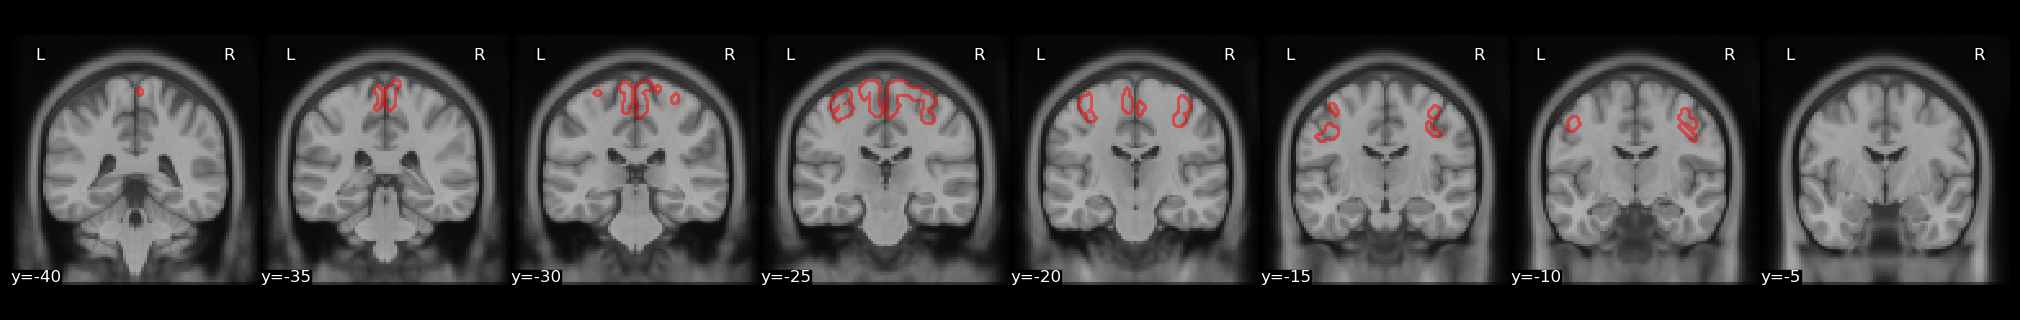

In [88]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="y", cut_coords=list(range(-40,0,5)), figure=fig
)
masks = [area4_ju]
colors = ["red", "blue", "limegreen",'orange']
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )

plt.show()

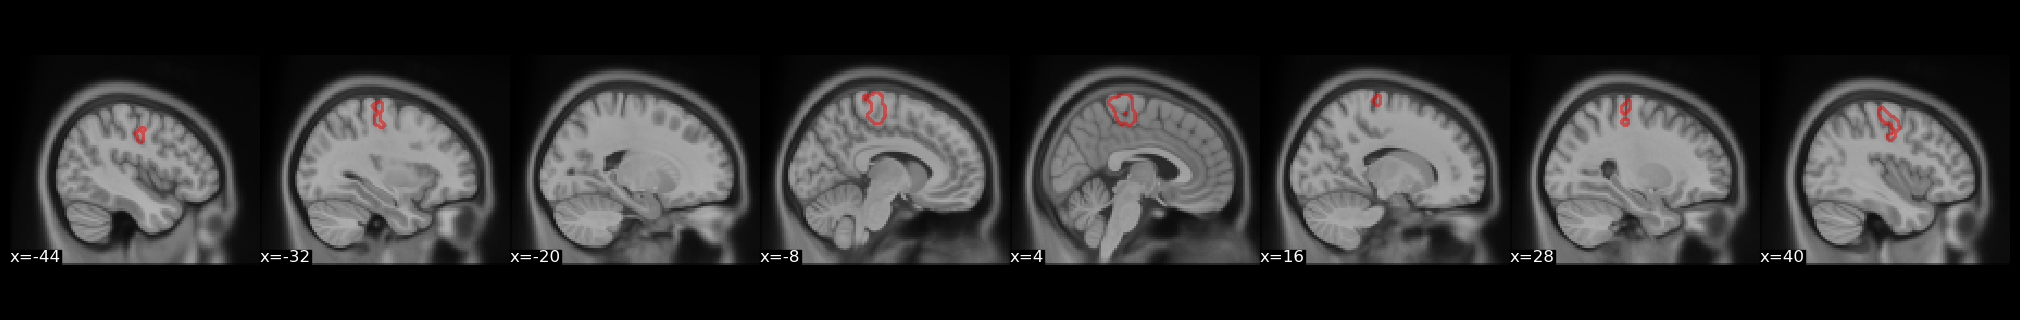

In [89]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(20,3), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="x", cut_coords=list(range(-44,44,12)), figure=fig
)
masks = [area4_ju]
colors = ["red", "blue", "limegreen",'orange']
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )

plt.show()